# 1.CosAdam

# MNIST and CIFAR10


--- MNIST: Training with CosAdam ---

Training on MNIST for 15 epochs...
Epoch 1 (MNIST) => Train Loss: 0.3215, Train Acc: 0.8994 | Val Loss: 0.0851, Val Acc: 0.9730 | Time: 20.39 sec
Epoch 2 (MNIST) => Train Loss: 0.0849, Train Acc: 0.9736 | Val Loss: 0.0600, Val Acc: 0.9798 | Time: 18.61 sec
Epoch 3 (MNIST) => Train Loss: 0.0607, Train Acc: 0.9813 | Val Loss: 0.0517, Val Acc: 0.9844 | Time: 14.40 sec
Epoch 4 (MNIST) => Train Loss: 0.0506, Train Acc: 0.9844 | Val Loss: 0.0468, Val Acc: 0.9826 | Time: 14.10 sec
Epoch 5 (MNIST) => Train Loss: 0.0420, Train Acc: 0.9872 | Val Loss: 0.0480, Val Acc: 0.9848 | Time: 13.93 sec
Epoch 6 (MNIST) => Train Loss: 0.0374, Train Acc: 0.9889 | Val Loss: 0.0423, Val Acc: 0.9854 | Time: 13.91 sec
Epoch 7 (MNIST) => Train Loss: 0.0319, Train Acc: 0.9901 | Val Loss: 0.0401, Val Acc: 0.9876 | Time: 13.78 sec
Epoch 8 (MNIST) => Train Loss: 0.0280, Train Acc: 0.9914 | Val Loss: 0.0364, Val Acc: 0.9896 | Time: 13.94 sec
Epoch 9 (MNIST) => Train Loss: 0.0241,

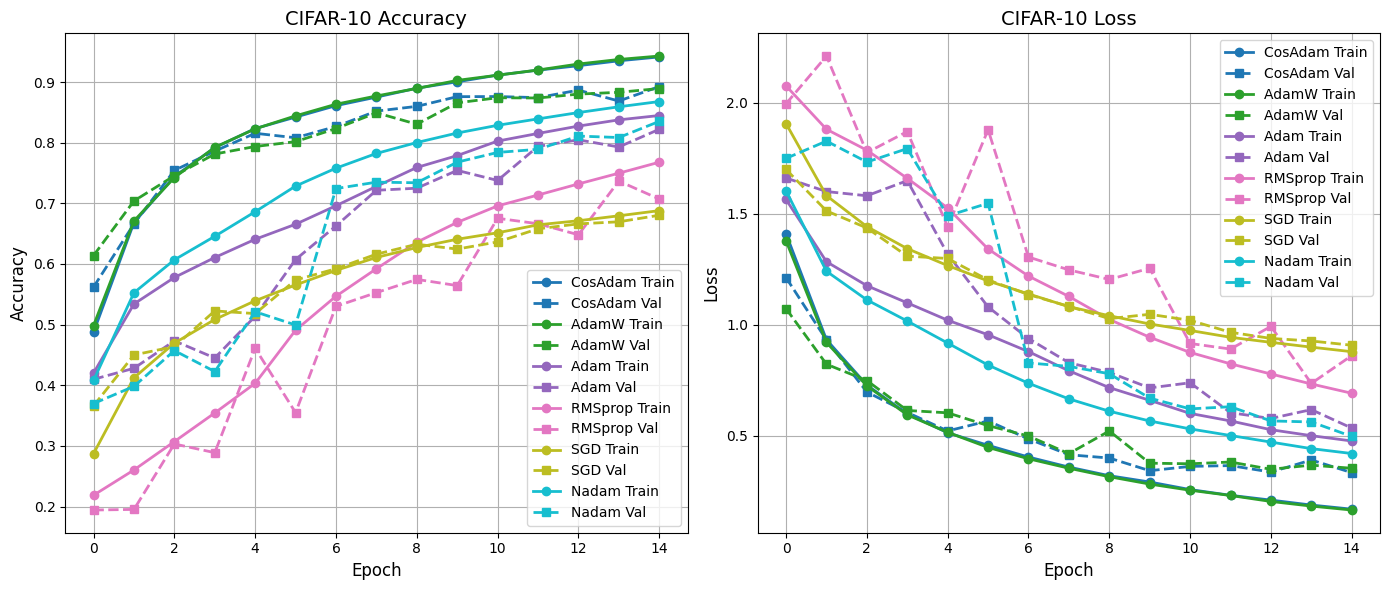

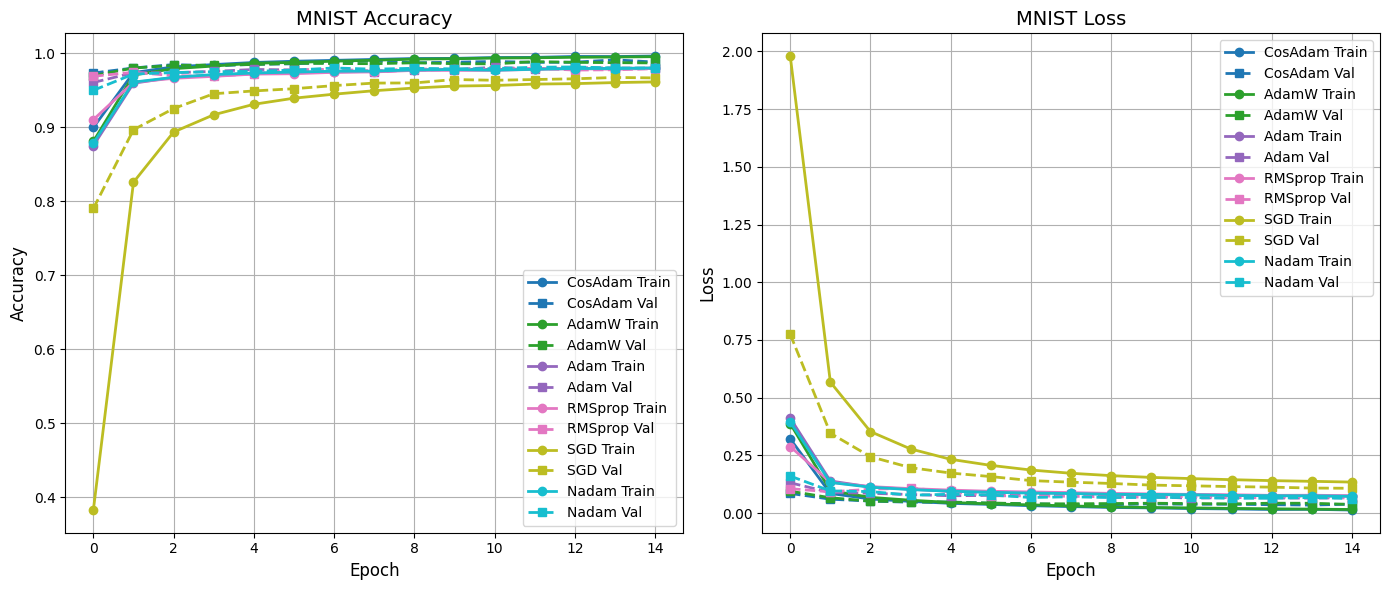

In [3]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize


# ---------------------------
# Reproducibility: Seed Initialization
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

epochs = 15


# ---------------------------
# CosAdam Optimizer (Improved Implementation)
# ---------------------------
class CosAdam(optim.Optimizer):
    """Implements CosAdam: Adam with cosine similarity-based step adjustment."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, alpha=0.9, c=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, alpha=alpha, c=c)
        super(CosAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # Initialize state
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                    state['s'] = 0.0  # Smoothed cosine similarity

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                prev_grad, s = state['prev_grad'], state['s']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Cosine similarity calculation (skip first step)
                if state['step'] > 1:
                    cos_theta = torch.cosine_similarity(grad.flatten(),
                                                       prev_grad.flatten(), dim=0)
                    s = group['alpha'] * s + (1 - group['alpha']) * cos_theta.item()
                state['s'] = s

                # Adam update components
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                denom = (exp_avg_sq.sqrt() / np.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                # Apply cosine scaling
                update = -step_size * exp_avg / denom
                update.mul_(1 + group['c'] * s)

                # Weight decay (AdamW style)
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * group['lr'])

                p.data.add_(update)
                state['prev_grad'].copy_(grad)

        return loss

# CIFAR-10: ResNet-18 Model (adapted)
class CIFAR10_ResNet(nn.Module):
    def __init__(self):
        super(CIFAR10_ResNet, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.model(x)

# MNIST: LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data Preparation
# CIFAR-10 transforms and datasets
transform_train_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_cifar)
testset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_cifar)
train_size_cifar, val_size_cifar = 45000, 5000
trainset_cifar, valset_cifar = random_split(trainset_cifar, [train_size_cifar, val_size_cifar])
train_loader_cifar = DataLoader(trainset_cifar, batch_size=128, shuffle=True, num_workers=2)
val_loader_cifar = DataLoader(valset_cifar, batch_size=128, shuffle=False, num_workers=2)
test_loader_cifar = DataLoader(testset_cifar, batch_size=128, shuffle=False, num_workers=2)

# MNIST transforms and datasets
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
train_size_mnist, val_size_mnist = 55000, 5000
trainset_mnist, valset_mnist = random_split(trainset_mnist, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(trainset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(valset_mnist, batch_size=128, shuffle=False, num_workers=2)
test_loader_mnist = DataLoader(testset_mnist, batch_size=128, shuffle=False, num_workers=2)

# Training Function (Generalized)
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader, num_epochs=3, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    overall_start_time = time.time()

    metrics = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'test_loss': 0.0, 'test_acc': 0.0,
        'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0,
        'probs': [], 'targets': [],
        'total_time': 0.0
    }

    print(f"\nTraining on {dataset_name} for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct / total
        metrics['train_loss'].append(epoch_train_loss)
        metrics['train_acc'].append(epoch_train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        metrics['val_loss'].append(epoch_val_loss)
        metrics['val_acc'].append(epoch_val_acc)

        writer.add_scalar(f"{dataset_name}/Train Loss", epoch_train_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Train Accuracy", epoch_train_acc, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Loss", epoch_val_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Accuracy", epoch_val_acc, epoch)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} ({dataset_name}) => Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} | Time: {epoch_time:.2f} sec")

        scheduler.step()

    total_training_time = time.time() - overall_start_time
    metrics['total_time'] = total_training_time

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    probs, targets_all = [], []
    with torch.no_grad():
        for data, t in test_loader:
            data, t = data.to(device), t.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, t).item()
            _, predicted = outputs.max(1)
            total += t.size(0)
            correct += predicted.eq(t).sum().item()
            probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            targets_all.extend(t.cpu().numpy())
    metrics['test_loss'] = test_loss / len(test_loader)
    metrics['test_acc'] = correct / total
    metrics['probs'] = np.array(probs)
    metrics['targets'] = np.array(targets_all)

    preds = np.argmax(metrics['probs'], axis=1)
    precision = precision_score(metrics['targets'], preds, average='macro')
    recall = recall_score(metrics['targets'], preds, average='macro')
    accuracy = accuracy_score(metrics['targets'], preds)
    f1 = f1_score(metrics['targets'], preds, average='macro')
    metrics['test_precision'] = precision
    metrics['test_recall'] = recall
    metrics['test_acc'] = accuracy
    metrics['test_f1'] = f1

    print(f"\nFinal Test Results on {dataset_name}:")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}")
    print(f"Total Training Time: {total_training_time:.2f} seconds\n")

    writer.close()
    return metrics

# Optimizers Setup (Nova removed)
optimizers = {
    'CosAdam': lambda p: CosAdam(p, lr=0.001, weight_decay=0.01),
    'AdamW': lambda p: optim.AdamW(p, lr=0.001, weight_decay=0.01),
    'Adam': lambda params: optim.Adam(params, lr=0.001, weight_decay=0.01),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.001, weight_decay=0.01),
    'SGD': lambda params: optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.01),
    'Nadam': lambda params: optim.NAdam(params, lr=0.001, weight_decay=0.01)
}


# Run Experiments for MNIST (LeNet-5)
results_mnist = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- MNIST: Training with {opt_name} ---')
    results_mnist[opt_name] = train_model(LeNet5, opt_factory,
                                          train_loader_mnist, val_loader_mnist, test_loader_mnist,
                                          num_epochs=epochs, dataset_name="MNIST")
# Run Experiments for CIFAR-10 (ResNet-18)
results_cifar = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- CIFAR-10: Training with {opt_name} ---')
    results_cifar[opt_name] = train_model(CIFAR10_ResNet, opt_factory,
                                          train_loader_cifar, val_loader_cifar, test_loader_cifar,
                                          num_epochs=epochs, dataset_name="CIFAR-10")



# Try to use the 'seaborn-darkgrid' style; if not available, fall back to default.
try:
    plt.style.use('seaborn-darkgrid')
except OSError:
    print("Style 'seaborn-darkgrid' not available. Falling back to default style.")
    plt.style.use('default')

# Plotting Learning Curves for CIFAR-10
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(results_cifar)))
for idx, opt in enumerate(results_cifar):
    axes[0].plot(results_cifar[opt]['train_acc'], marker='o',
                 color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[0].plot(results_cifar[opt]['val_acc'], marker='s',
                 color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[0].set_title('CIFAR-10 Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
for idx, opt in enumerate(results_cifar):
    axes[1].plot(results_cifar[opt]['train_loss'], marker='o',
                 color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[1].plot(results_cifar[opt]['val_loss'], marker='s',
                 color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[1].set_title('CIFAR-10 Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
plt.tight_layout()
plt.show()

# Plotting Learning Curves for MNIST
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors_mnist = plt.cm.tab10(np.linspace(0, 1, len(results_mnist)))
for idx, opt in enumerate(results_mnist):
    axes[0].plot(results_mnist[opt]['train_acc'], marker='o',
                 color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[0].plot(results_mnist[opt]['val_acc'], marker='s',
                 color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[0].set_title('MNIST Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
for idx, opt in enumerate(results_mnist):
    axes[1].plot(results_mnist[opt]['train_loss'], marker='o',
                 color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[1].plot(results_mnist[opt]['val_loss'], marker='s',
                 color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[1].set_title('MNIST Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
plt.tight_layout()
plt.show()

Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Neither 'seaborn-darkgrid' nor 'seaborn' are available. Using default style.


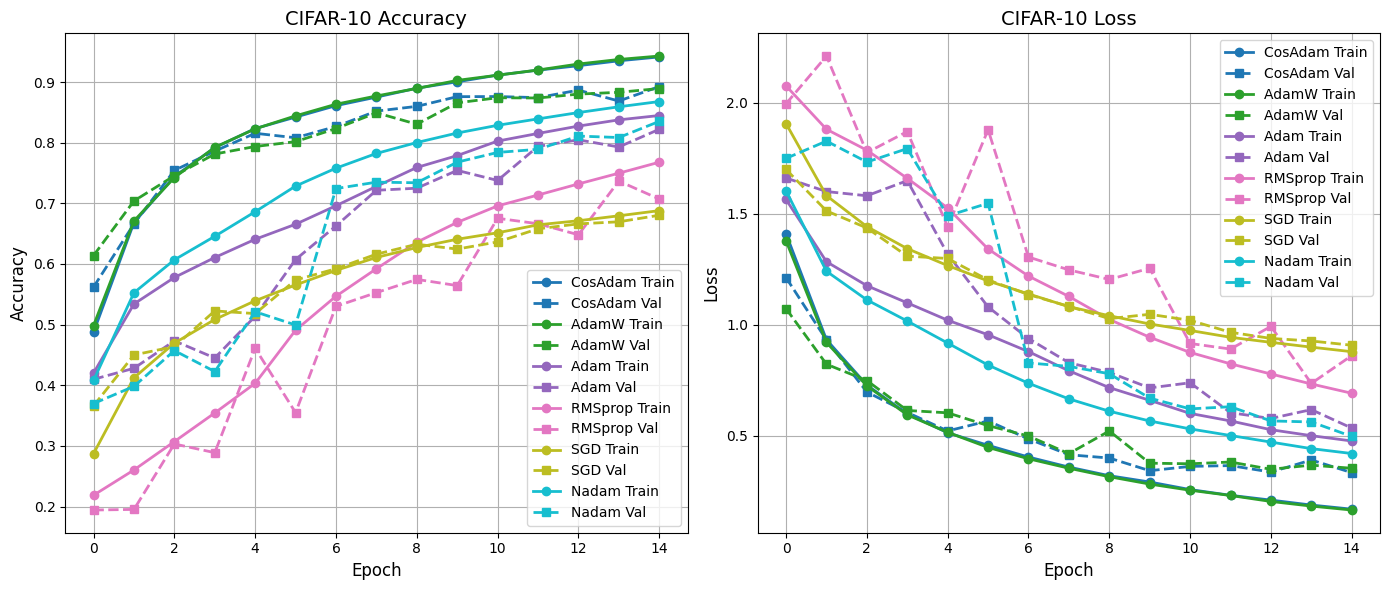

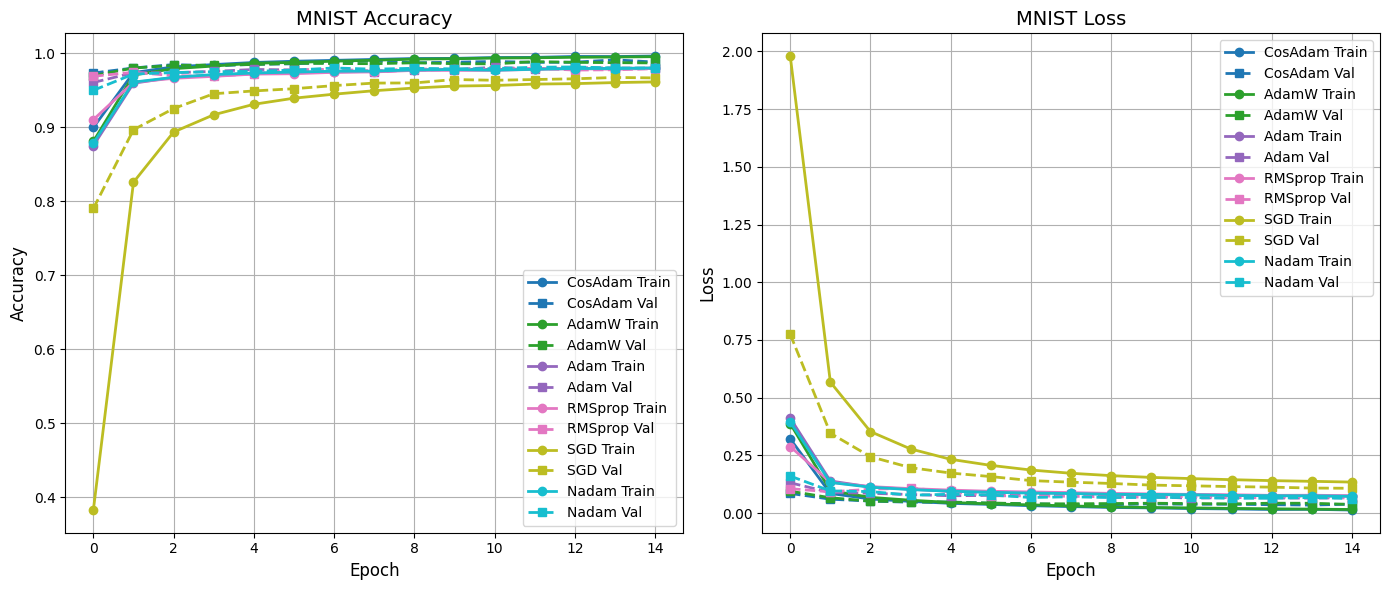

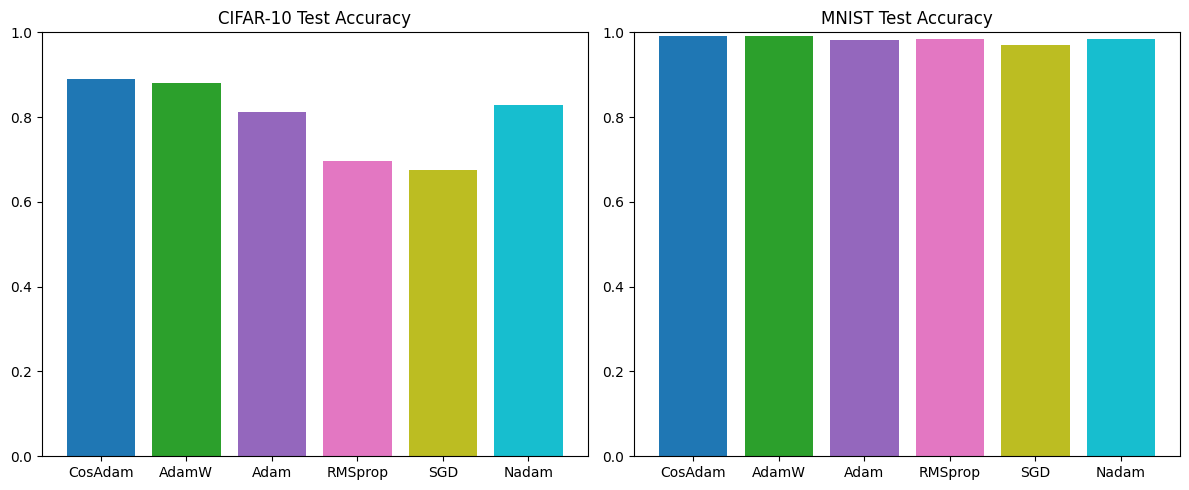

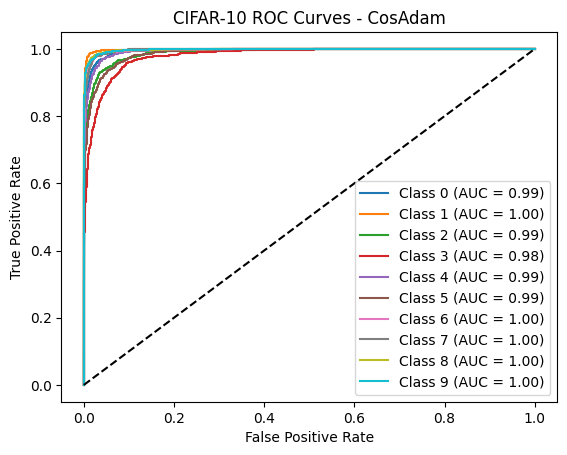

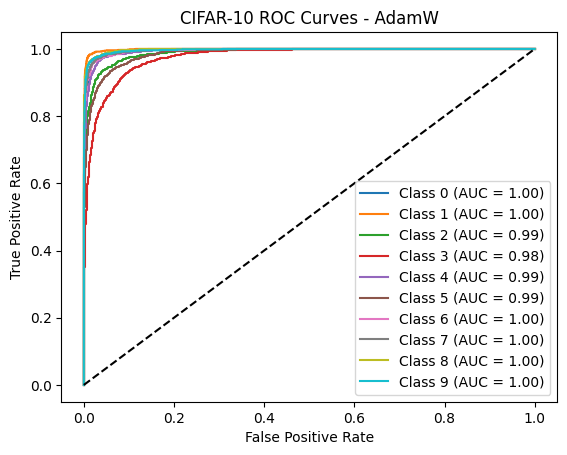

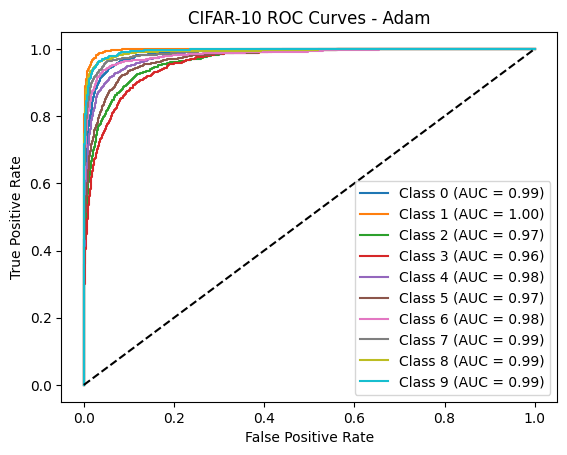

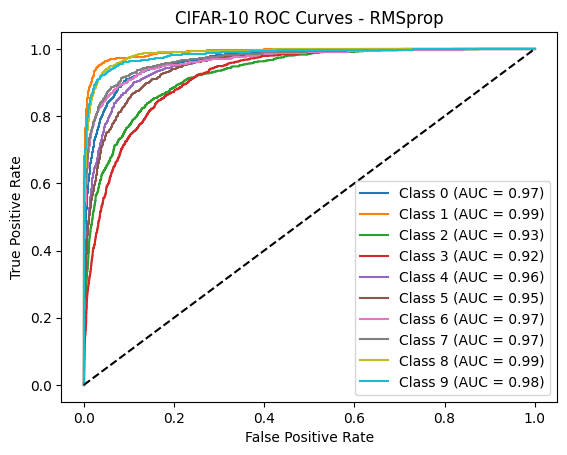

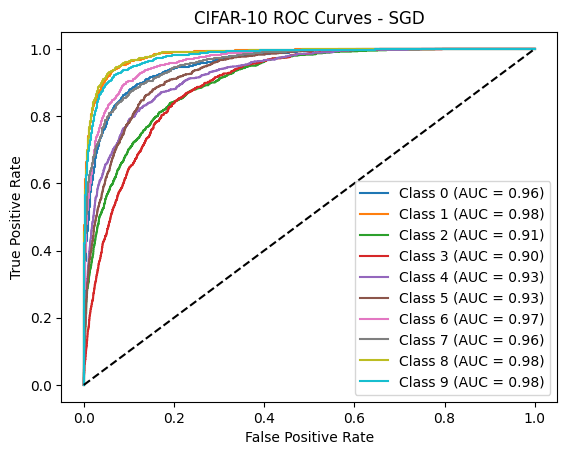

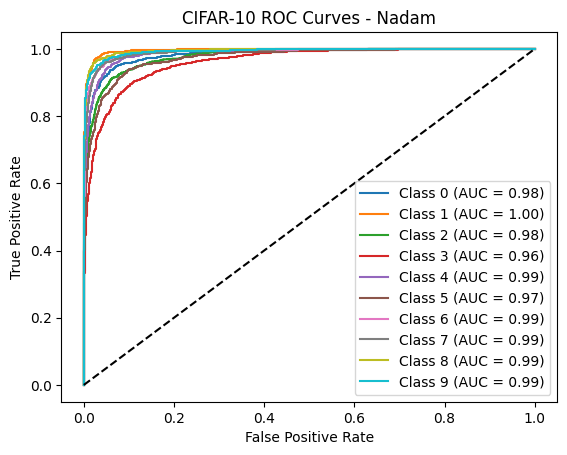

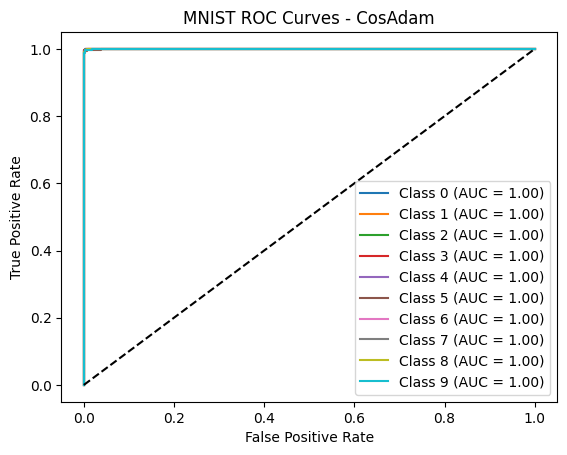

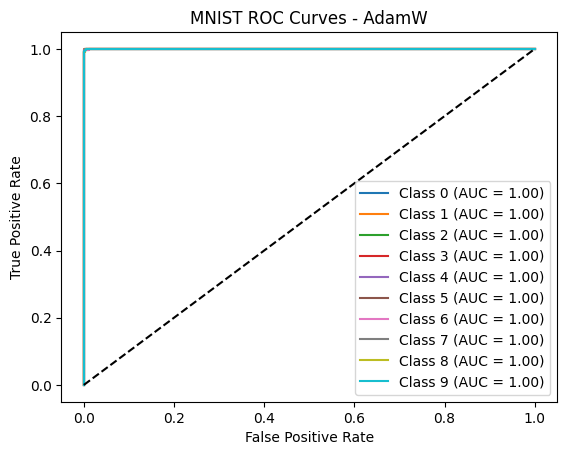

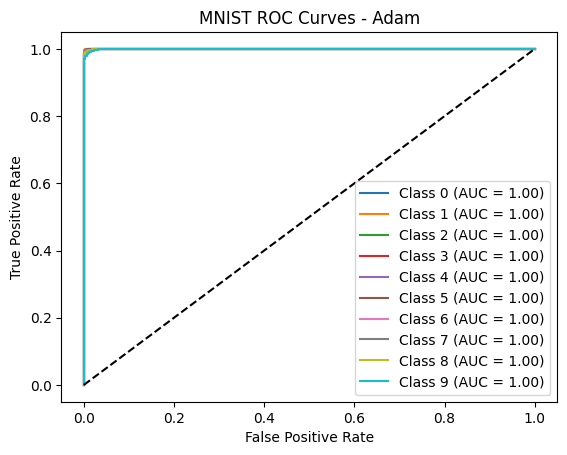

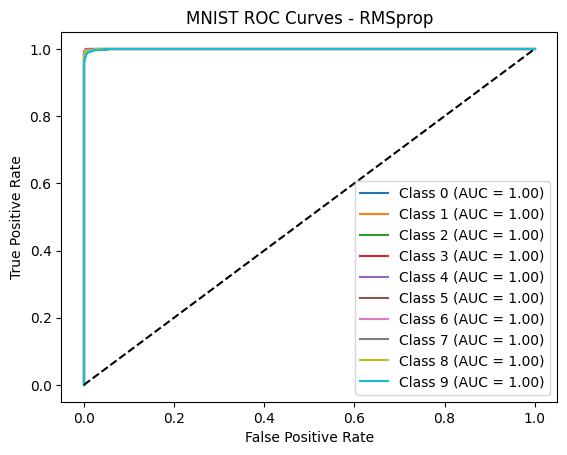

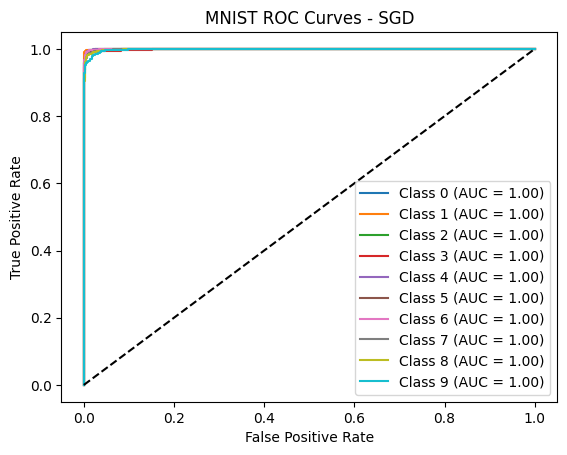

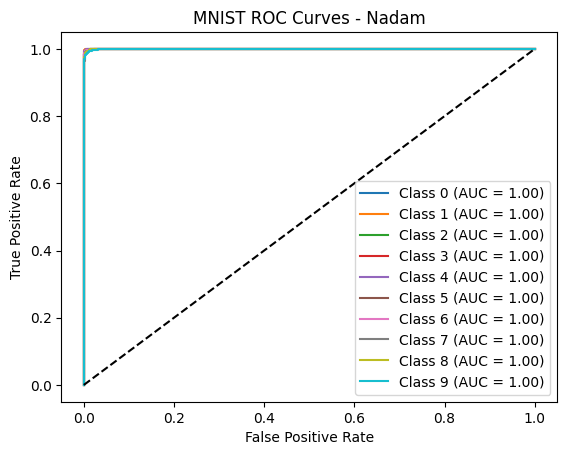

In [ ]:


import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import label_binarize

# Print available styles to check what you can use
print("Available styles:", plt.style.available)

# Try to use 'seaborn-darkgrid', if not available try 'seaborn', otherwise default
if 'seaborn-darkgrid' in plt.style.available:
    plt.style.use('seaborn-darkgrid')
elif 'seaborn' in plt.style.available:
    print("'seaborn-darkgrid' not available; using 'seaborn' instead.")
    plt.style.use('seaborn')
else:
    print("Neither 'seaborn-darkgrid' nor 'seaborn' are available. Using default style.")
    plt.style.use('default')

# ---------------------------
# Plotting Learning Curves for CIFAR-10
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Generate distinct colors for each optimizer using the tab10 colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(results_cifar)))

# Accuracy Plot for CIFAR-10
for idx, opt in enumerate(results_cifar):
    axes[0].plot(results_cifar[opt]['train_acc'], marker='o',
                 color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[0].plot(results_cifar[opt]['val_acc'], marker='s',
                 color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[0].set_title('CIFAR-10 Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Loss Plot for CIFAR-10
for idx, opt in enumerate(results_cifar):
    axes[1].plot(results_cifar[opt]['train_loss'], marker='o',
                 color=colors[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[1].plot(results_cifar[opt]['val_loss'], marker='s',
                 color=colors[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[1].set_title('CIFAR-10 Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ---------------------------
# Plotting Learning Curves for MNIST
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Generate distinct colors for each optimizer for MNIST using the tab10 colormap
colors_mnist = plt.cm.tab10(np.linspace(0, 1, len(results_mnist)))

# Accuracy Plot for MNIST
for idx, opt in enumerate(results_mnist):
    axes[0].plot(results_mnist[opt]['train_acc'], marker='o',
                 color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[0].plot(results_mnist[opt]['val_acc'], marker='s',
                 color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[0].set_title('MNIST Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Loss Plot for MNIST
for idx, opt in enumerate(results_mnist):
    axes[1].plot(results_mnist[opt]['train_loss'], marker='o',
                 color=colors_mnist[idx], linestyle='-', linewidth=2, label=f'{opt} Train')
    axes[1].plot(results_mnist[opt]['val_loss'], marker='s',
                 color=colors_mnist[idx], linestyle='--', linewidth=2, label=f'{opt} Val')
axes[1].set_title('MNIST Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()




# ---------------------------
# Final Test Accuracy Bar Plot for CIFAR-10 and MNIST with Distinct Colors
# ---------------------------
final_acc_cifar = {opt: results_cifar[opt]['test_acc'] for opt in results_cifar}
final_acc_mnist = {opt: results_mnist[opt]['test_acc'] for opt in results_mnist}

# Generate distinct colors for each optimizer using the tab10 colormap
colors_cifar = plt.cm.tab10(np.linspace(0, 1, len(final_acc_cifar)))
colors_mnist = plt.cm.tab10(np.linspace(0, 1, len(final_acc_mnist)))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(final_acc_cifar.keys(), final_acc_cifar.values(), color=colors_cifar)
plt.ylim(0, 1)
plt.title('CIFAR-10 Test Accuracy')

plt.subplot(1, 2, 2)
plt.bar(final_acc_mnist.keys(), final_acc_mnist.values(), color=colors_mnist)
plt.ylim(0, 1)
plt.title('MNIST Test Accuracy')
plt.tight_layout()
plt.show()

# ---------------------------
# Confusion Matrix and ROC Curves for CIFAR-10
# ---------------------------
for opt in results_cifar:
    # ROC Curves for CIFAR-10
    y_true = label_binarize(results_cifar[opt]['targets'], classes=range(10))
    y_score = results_cifar[opt]['probs']
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    # Add axis labels to clarify the rates
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'CIFAR-10 ROC Curves - {opt}')
    plt.legend()
    plt.show()

# ---------------------------
# Confusion Matrix and ROC Curves for MNIST
# ---------------------------
for opt in results_mnist:
    # ROC Curves for MNIST
    y_true = label_binarize(results_mnist[opt]['targets'], classes=range(10))
    y_score = results_mnist[opt]['probs']
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    # Add axis labels to clarify the rates
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'MNIST ROC Curves - {opt}')
    plt.legend()
    plt.show()



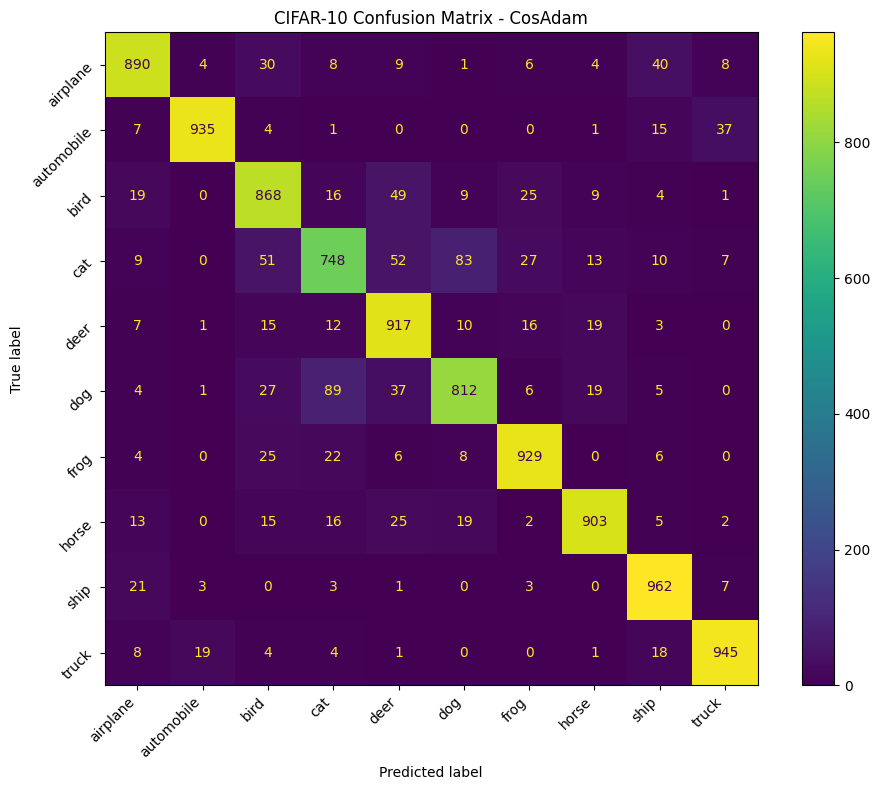

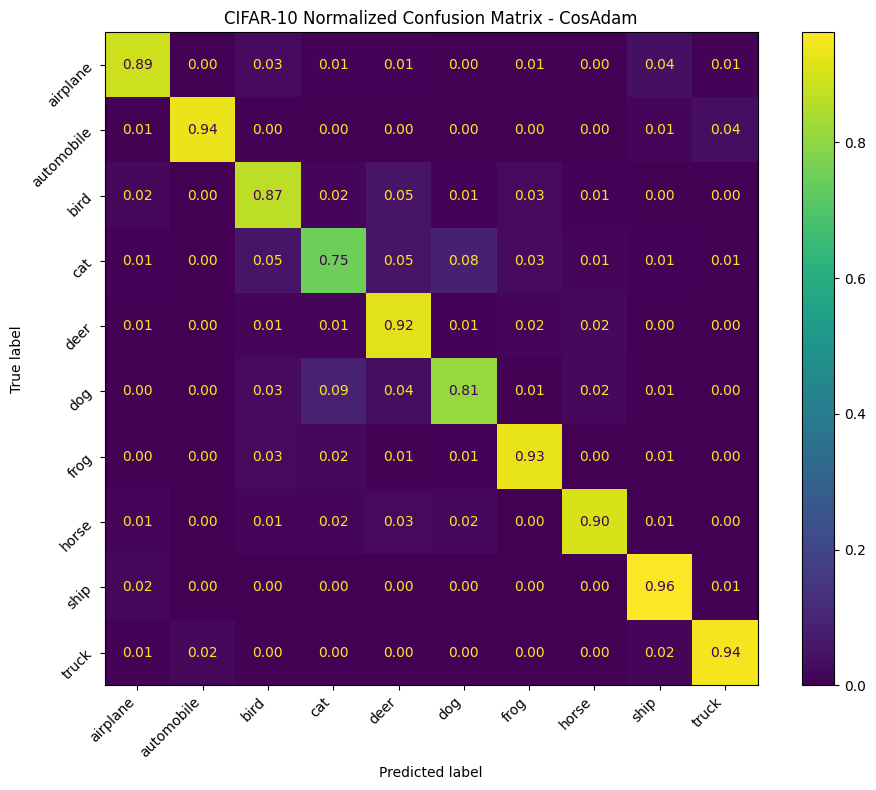

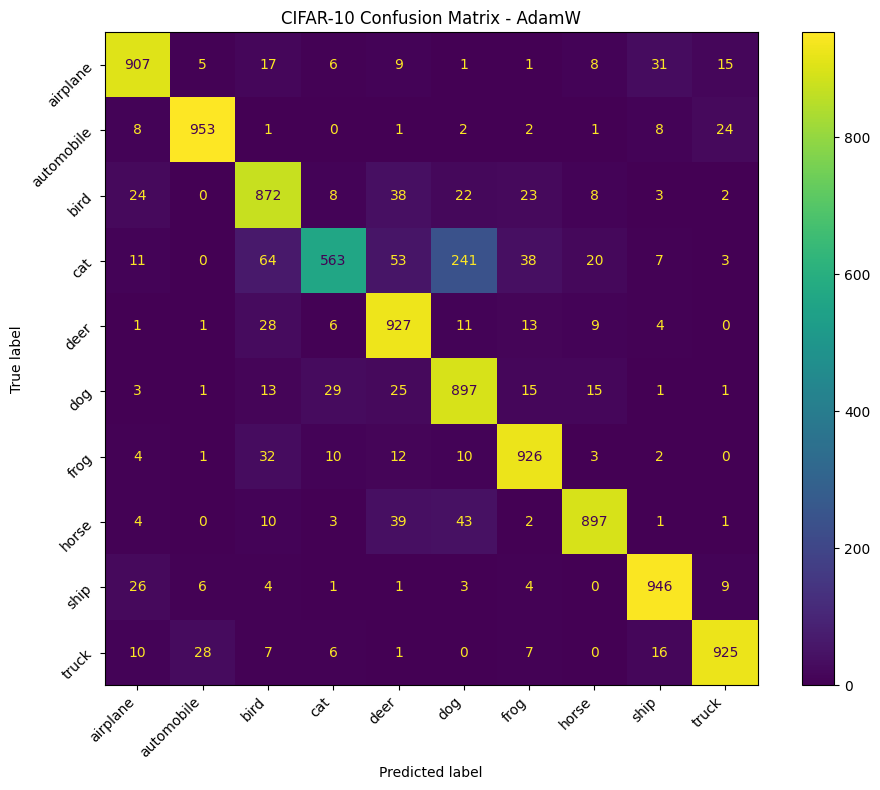

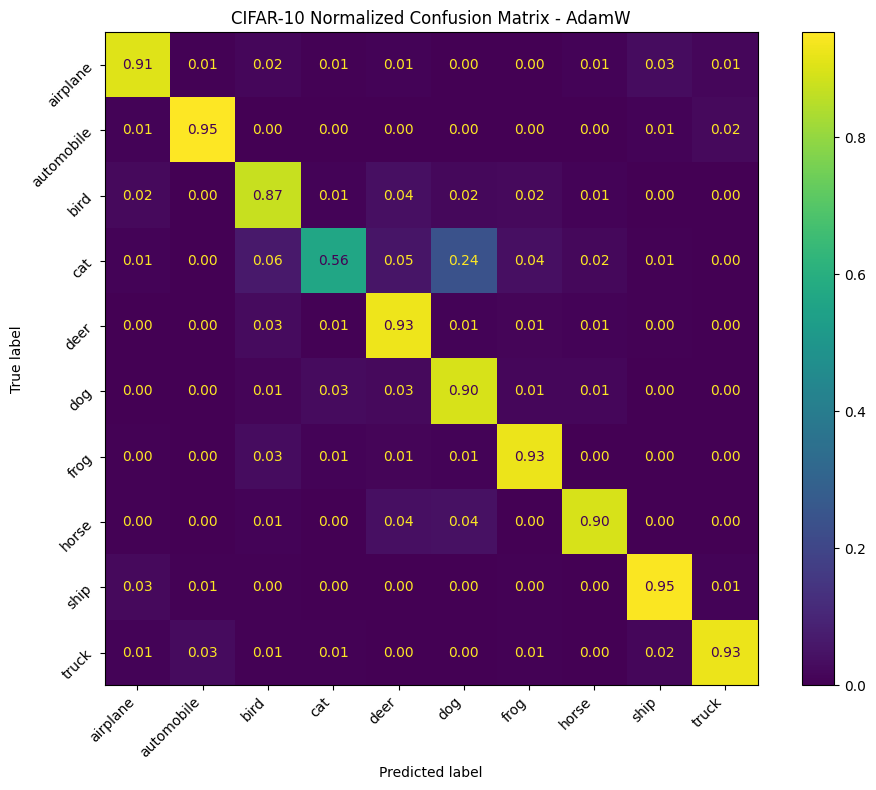

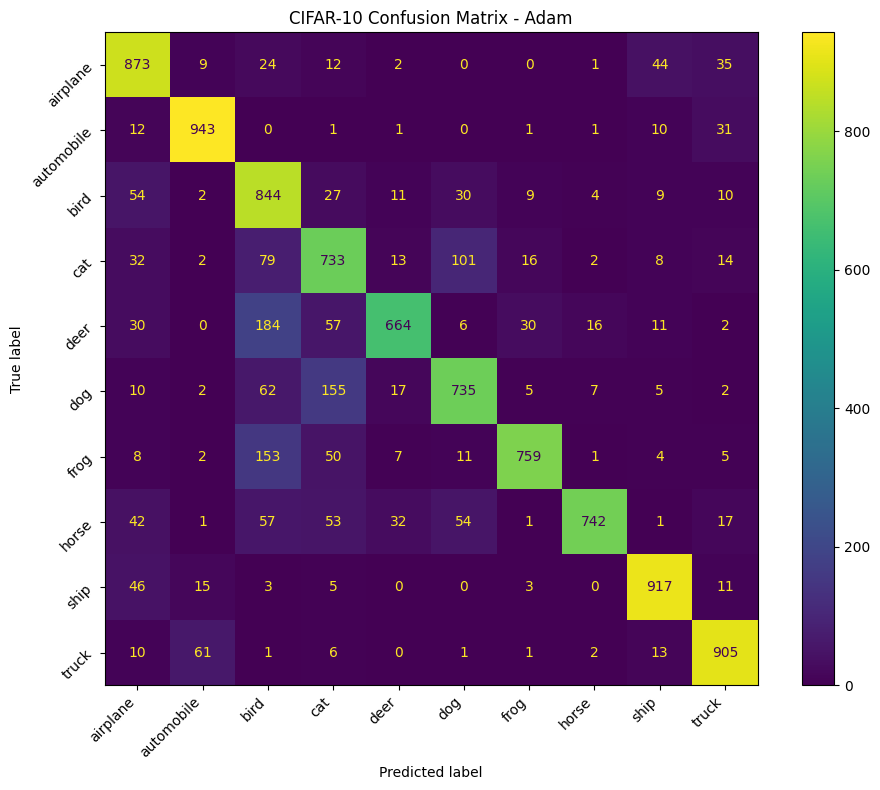

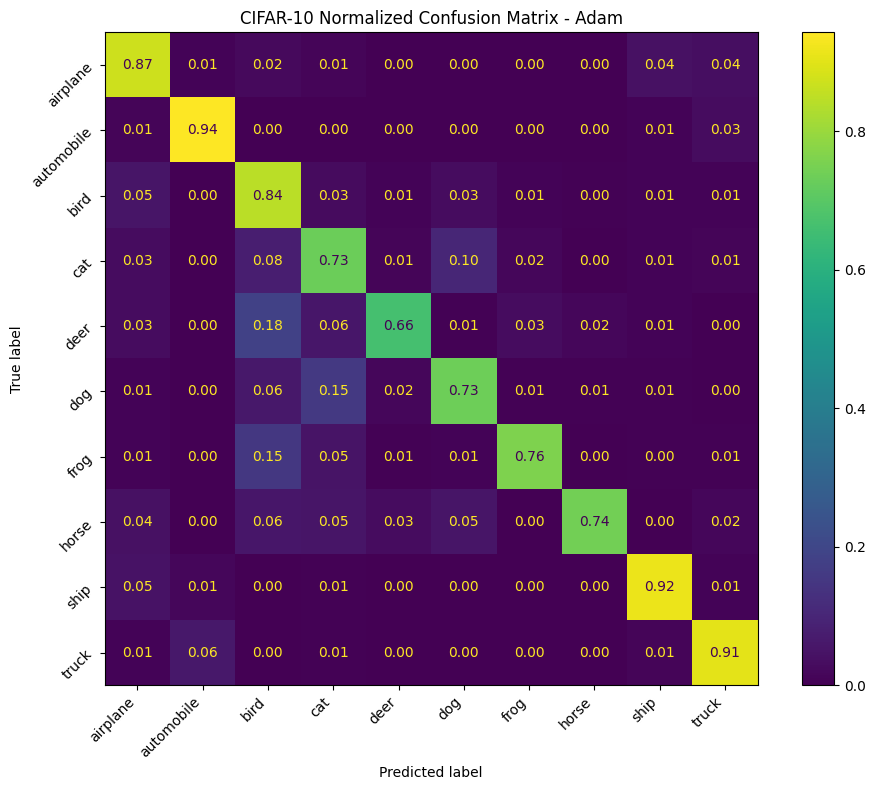

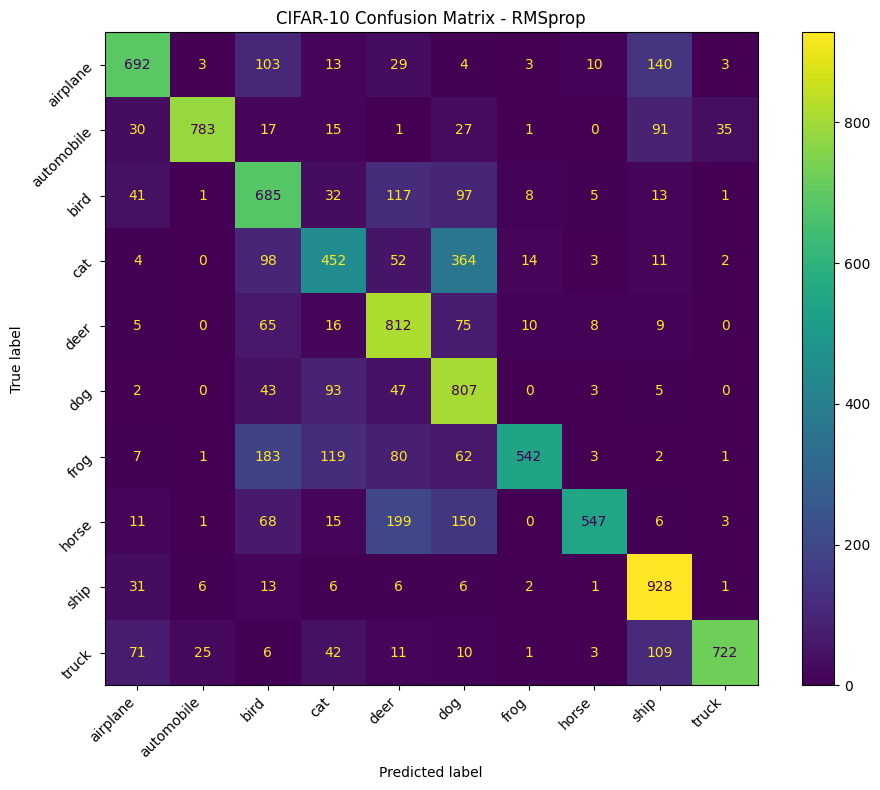

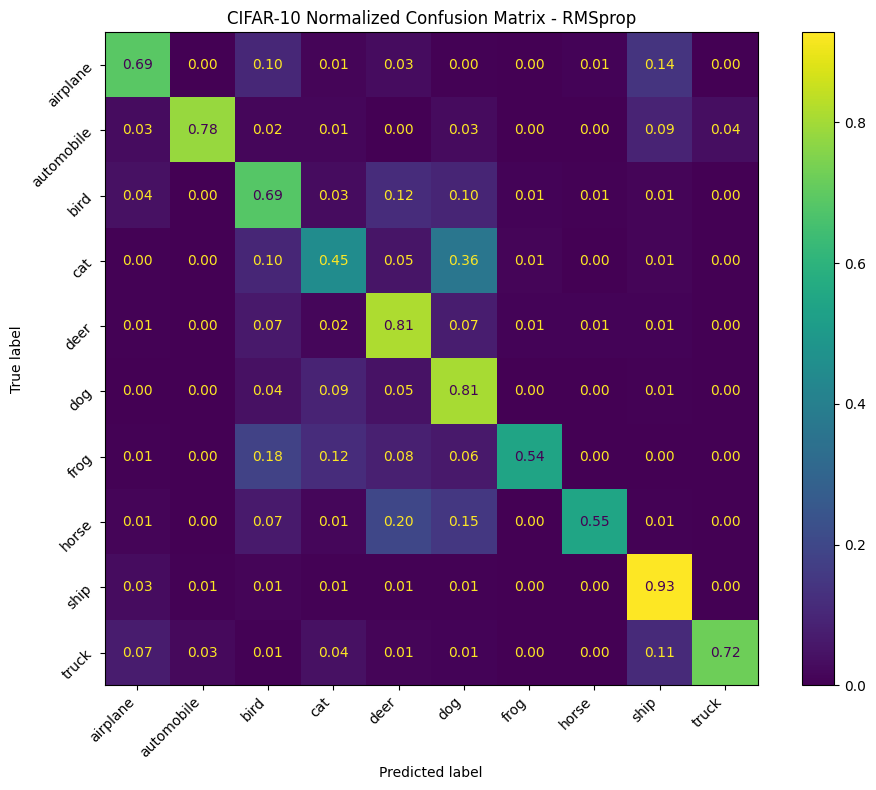

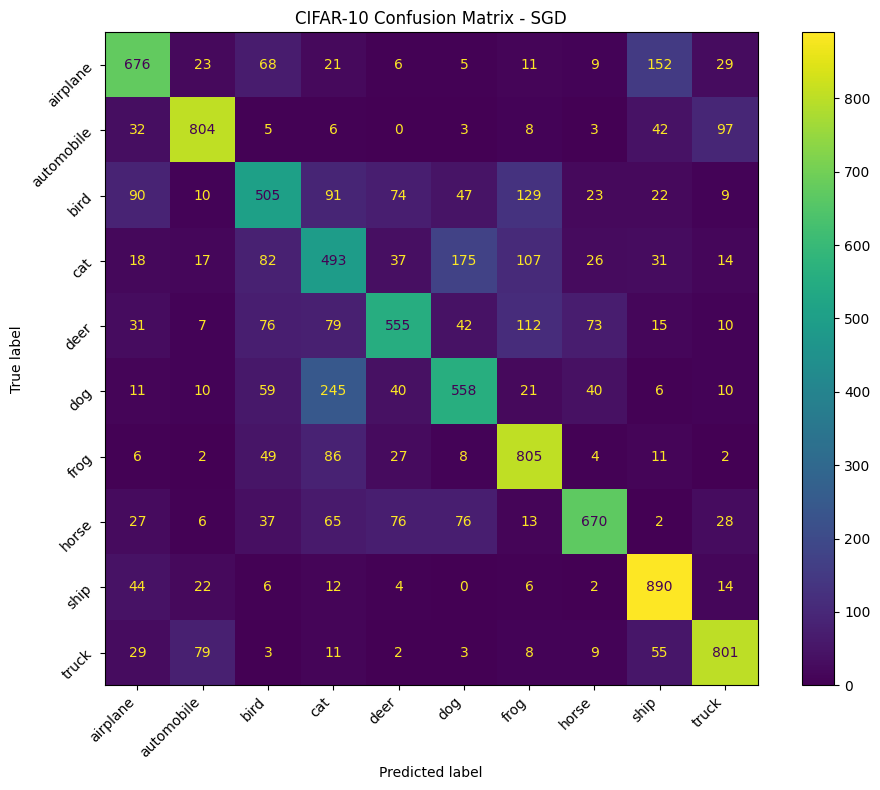

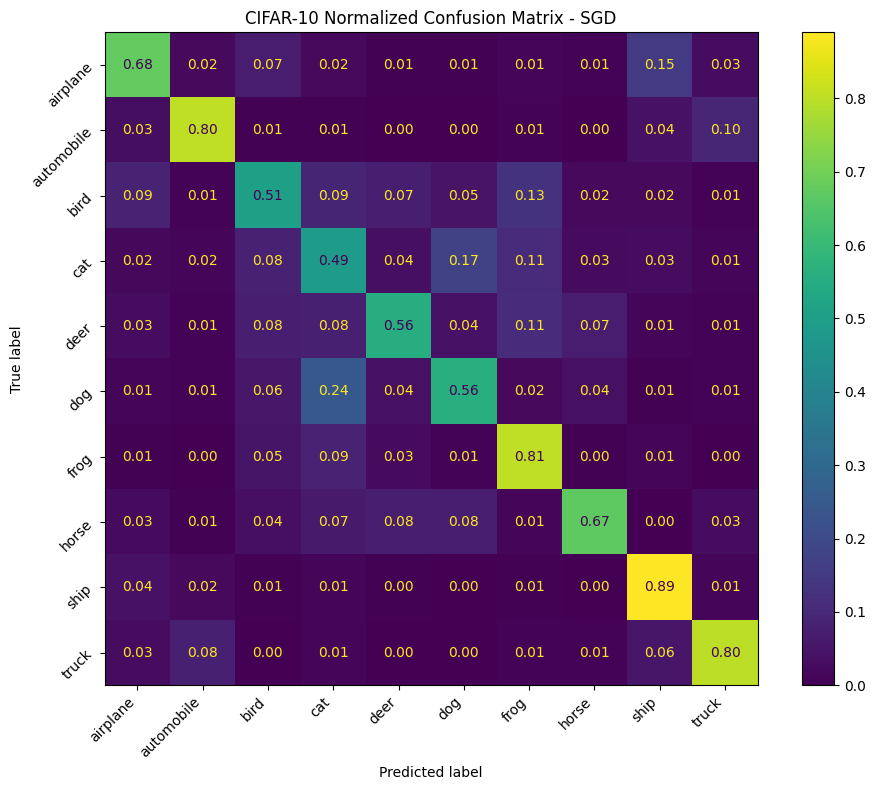

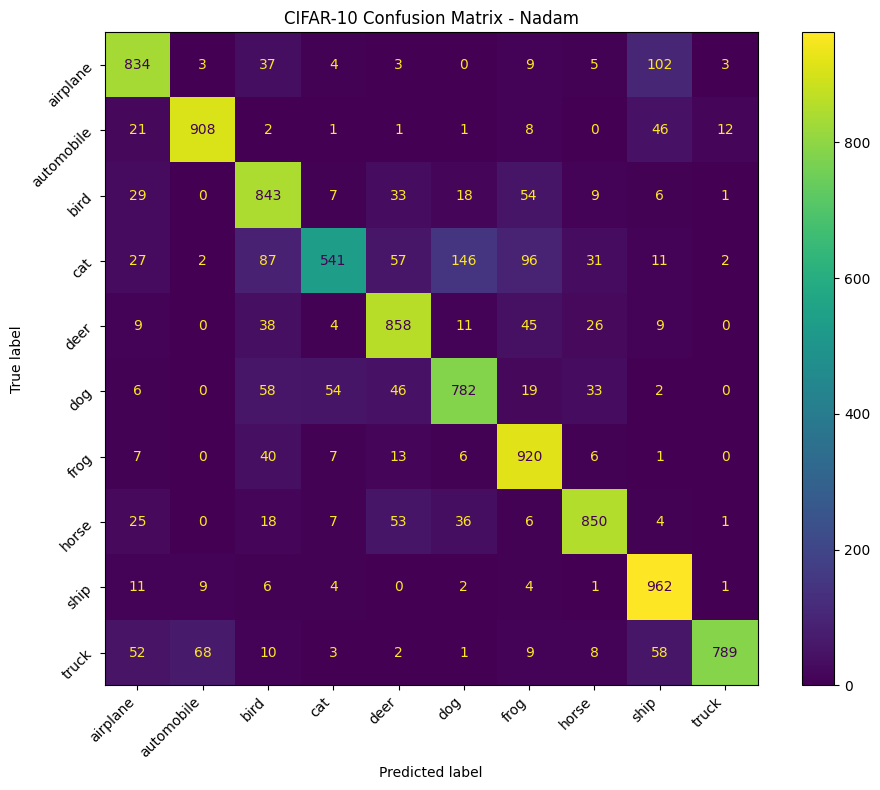

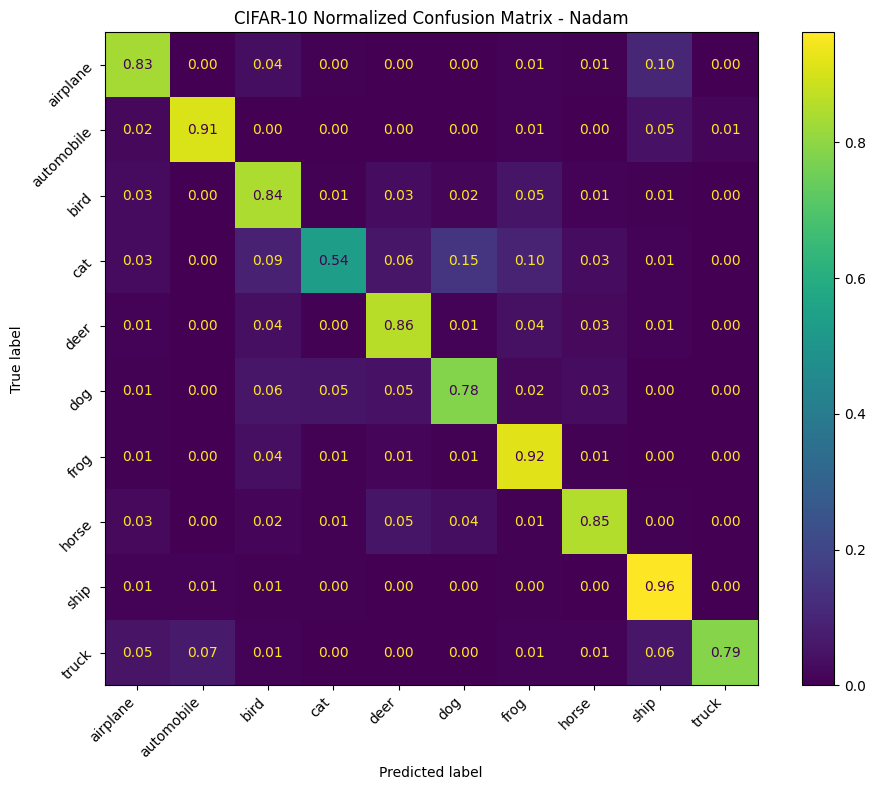

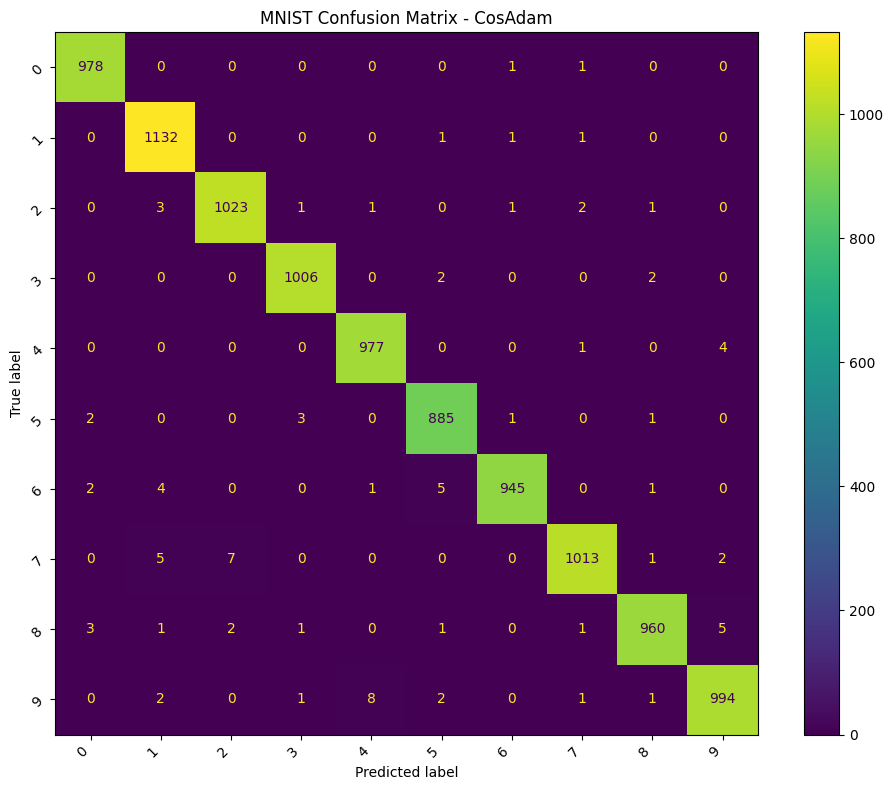

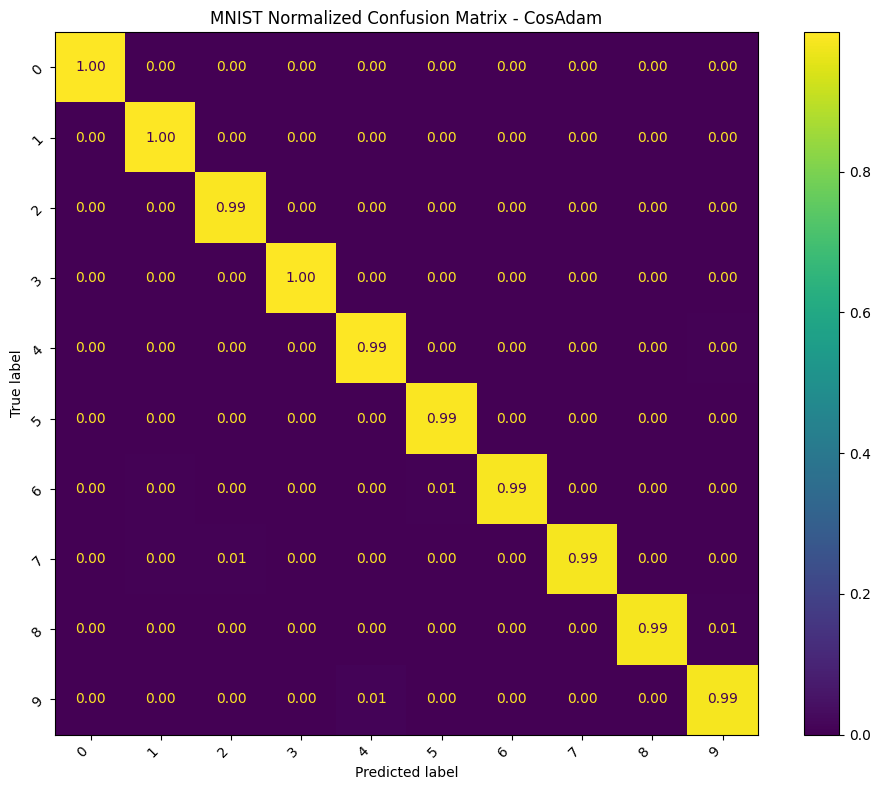

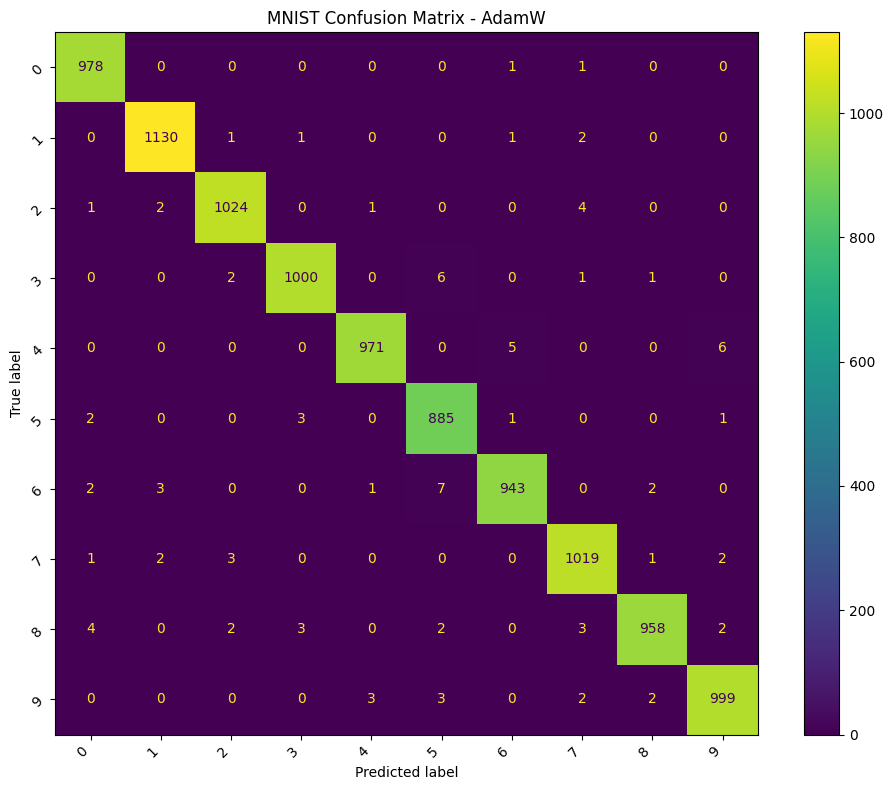

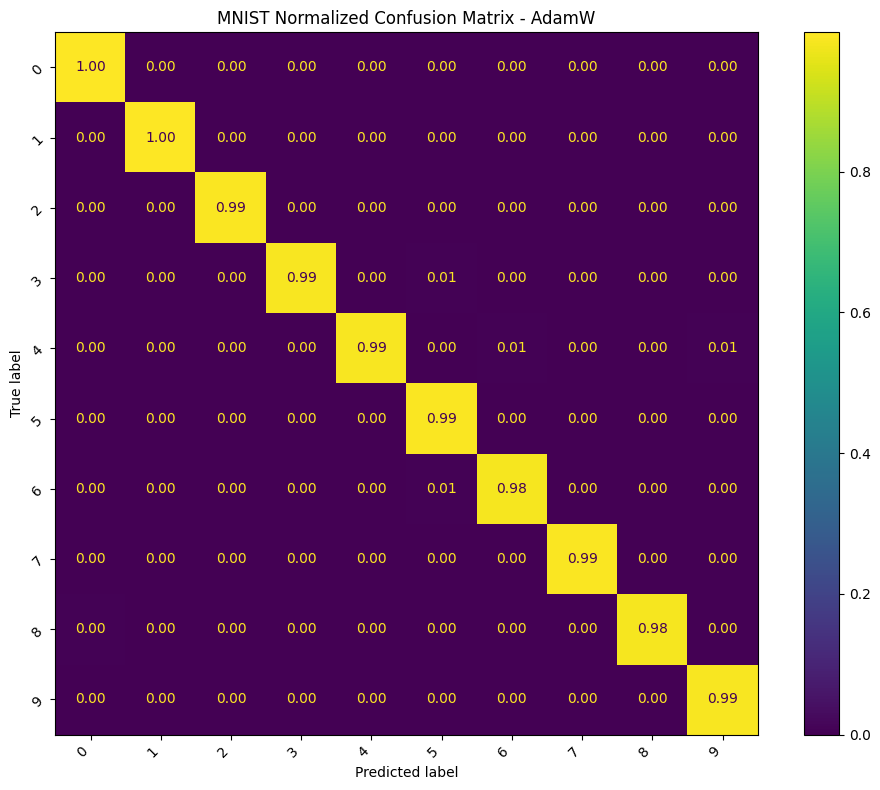

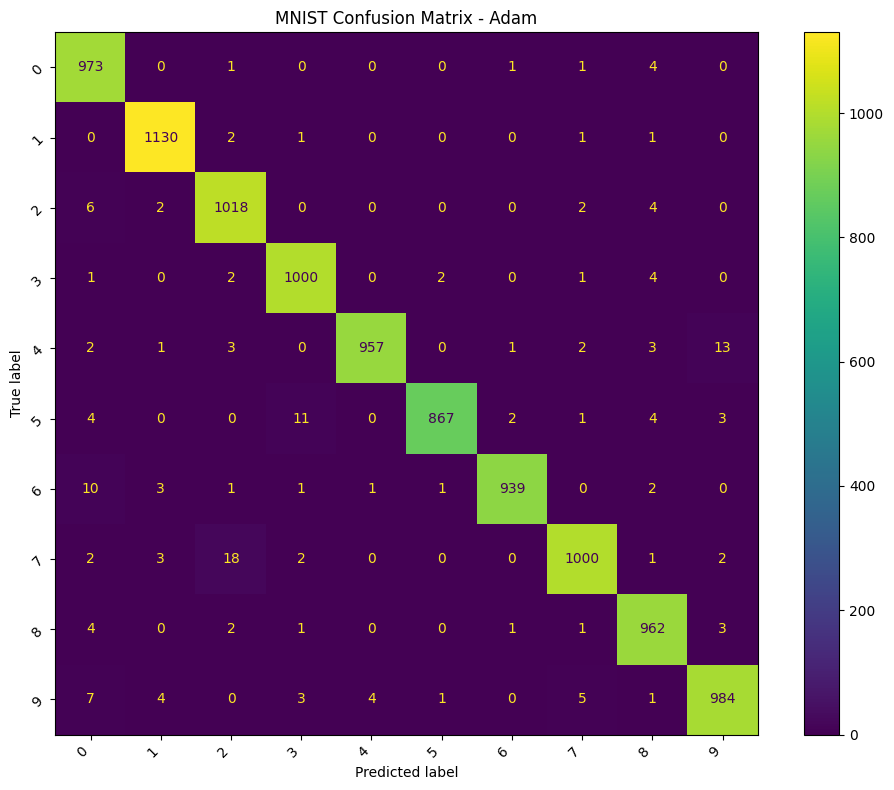

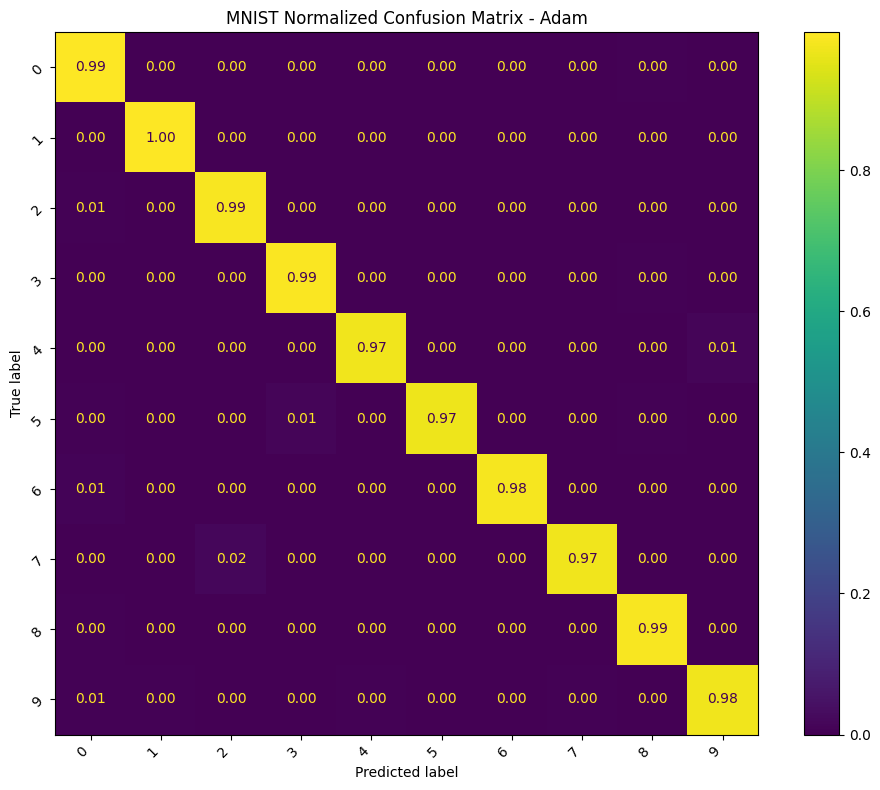

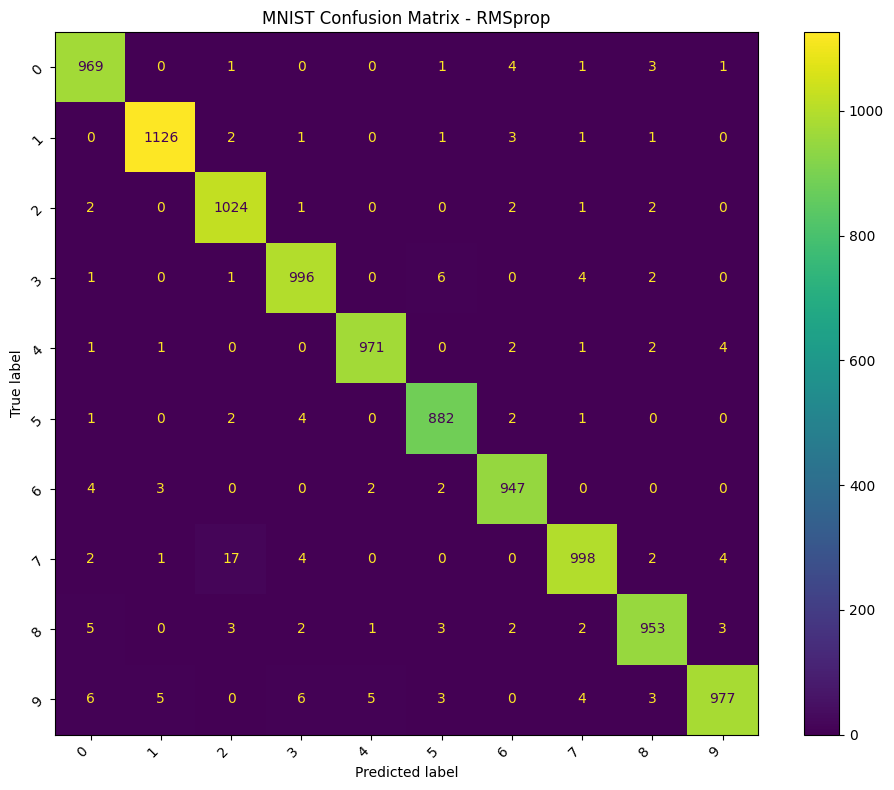

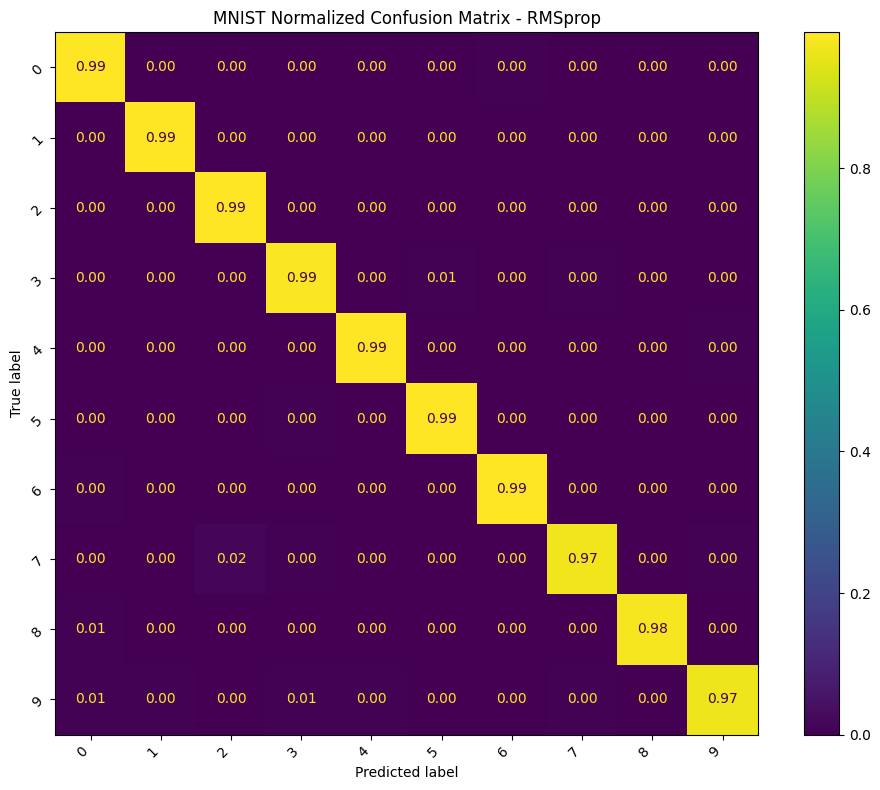

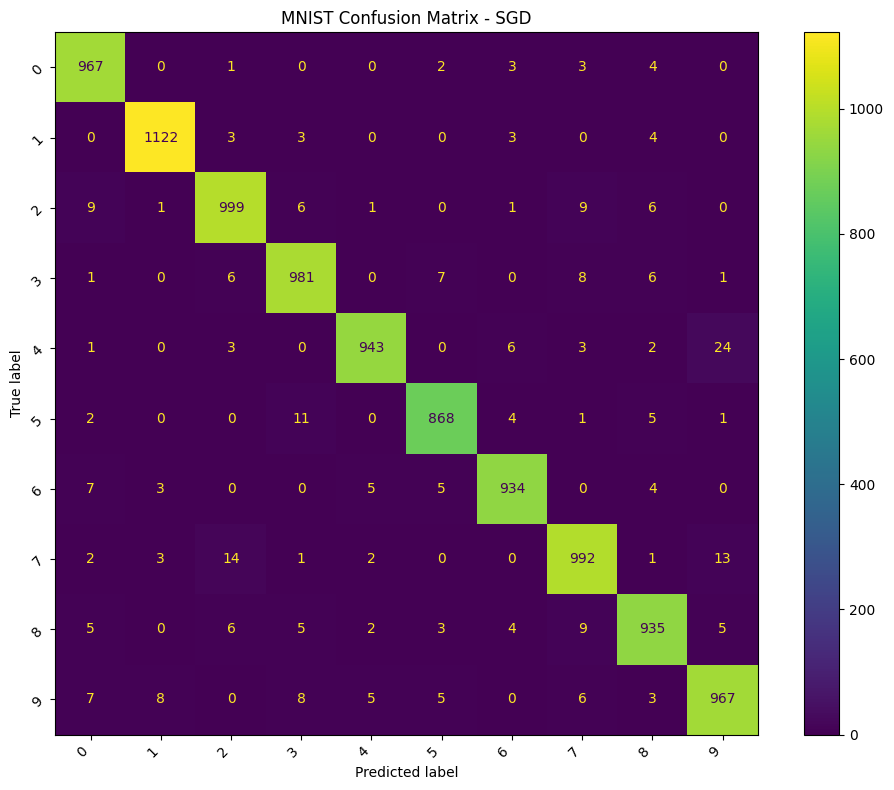

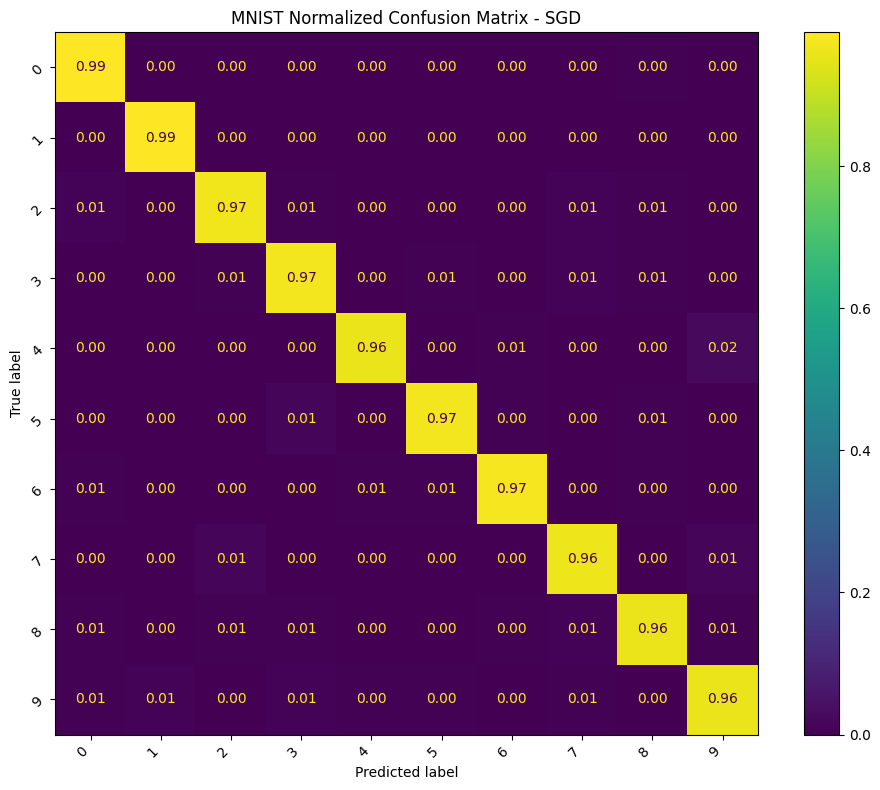

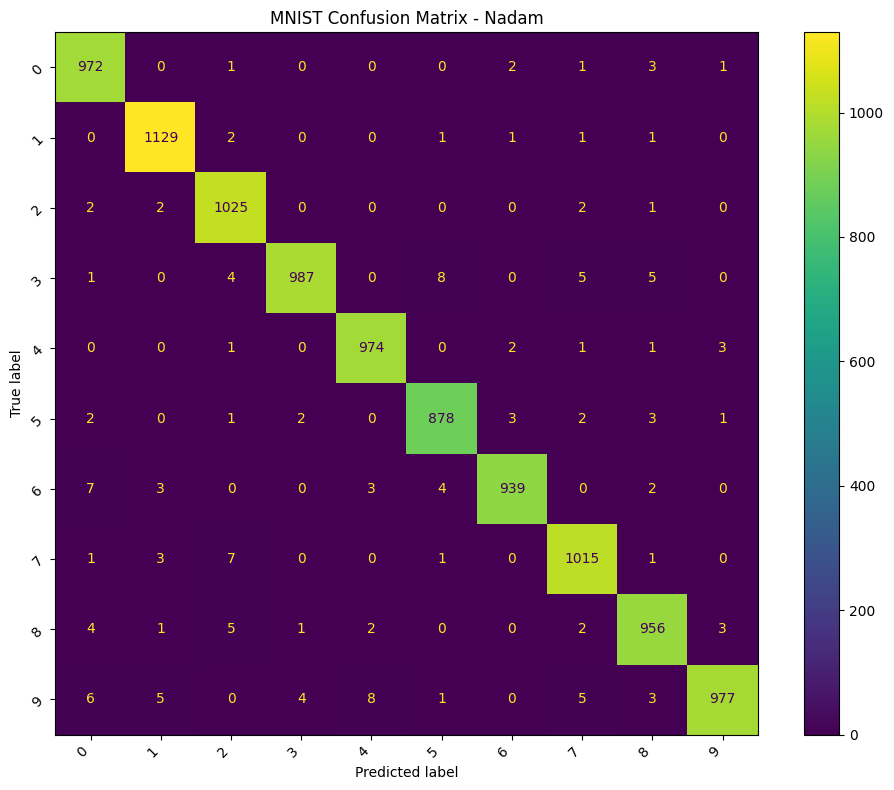

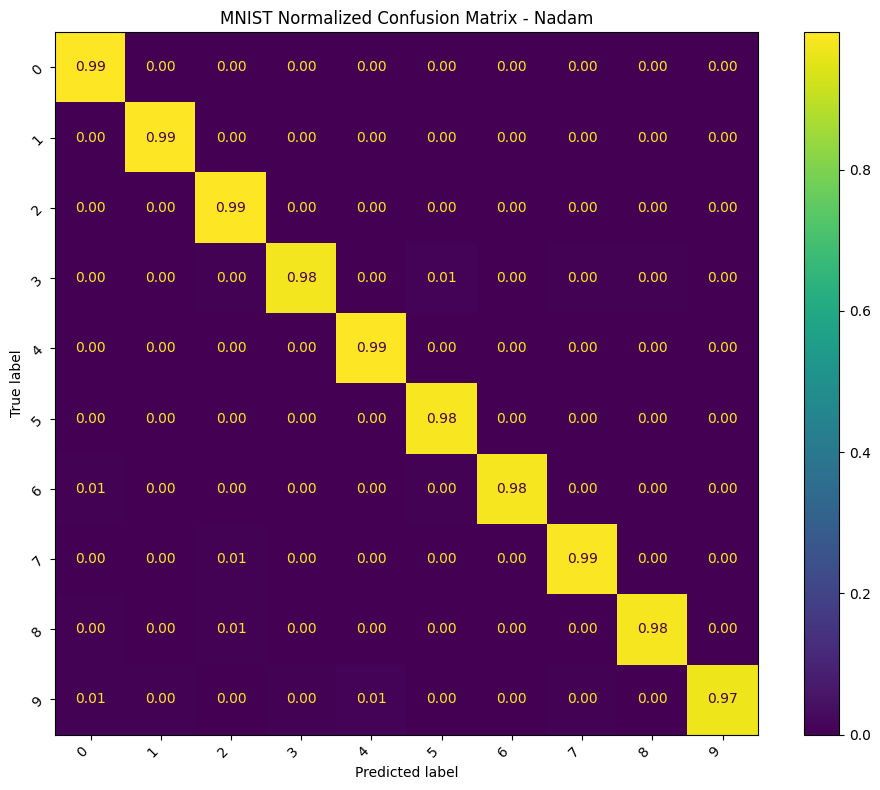

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot a confusion matrix with enhancements
def plot_confusion_matrix(cm, class_names, title, normalize=False):
    fig, ax = plt.subplots(figsize=(10, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        values_format = '.2f'  # Format for floating-point numbers
    else:
        values_format = 'd'    # Format for integers
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', ax=ax, values_format=values_format)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting confusion matrices for CIFAR-10
for opt in results_cifar:
    # Compute confusion matrix
    cm = confusion_matrix(results_cifar[opt]['targets'], np.argmax(results_cifar[opt]['probs'], axis=1))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, cifar10_class_names, f'CIFAR-10 Confusion Matrix - {opt}', normalize=False)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, cifar10_class_names, f'CIFAR-10 Normalized Confusion Matrix - {opt}', normalize=True)

# Plotting confusion matrices for MNIST
for opt in results_mnist:
    # Compute confusion matrix
    cm = confusion_matrix(results_mnist[opt]['targets'], np.argmax(results_mnist[opt]['probs'], axis=1))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, range(10), f'MNIST Confusion Matrix - {opt}', normalize=False)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, range(10), f'MNIST Normalized Confusion Matrix - {opt}', normalize=True)


In [ ]:
!pip install torchtext datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 120.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existi

In [6]:
pip install --upgrade datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


# SST-2

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loading SST-2...

--- SST-2: Training with CosAdam ---
Epoch 1/15 - Train Loss: 0.6107, Train Acc: 0.6696, Val Loss: 0.4947, Val Acc: 0.7807
Epoch 2/15 - Train Loss: 0.4106, Train Acc: 0.8348, Val Loss: 0.3681, Val Acc: 0.8520
Epoch 3/15 - Train Loss: 0.3165, Train Acc: 0.8798, Val Loss: 0.3166, Val Acc: 0.8726
Epoch 4/15 - Train Loss: 0.2712, Train Acc: 0.9004, Val Loss: 0.2892, Val Acc: 0.8812
Epoch 5/15 - Train Loss: 0.2422, Train Acc: 0.9119, Val Loss: 0.2729, Val Acc: 0.8909
Epoch 6/15 - Train Loss: 0.2225, Train Acc: 0.9195, Val Loss: 0.2627, Val Acc: 0.8977
Epoch 7/15 - Train Loss: 0.2083, Train Acc: 0.9252, Val Loss: 0.2567, Val Acc: 0.9008
Epoch 8/15 - Train Loss: 0.1971, Train Acc: 0.9291, Val Loss: 0.2525, Val Acc: 0.9029
Epoch 9/15 - Train Loss: 0.1879, Train Acc: 0.9324, Val Loss: 0.2495, Val Acc: 0.9039
Epoch 10/15 - Train Loss: 0.1809, Train Acc: 0.9350, Val Loss: 0.2477, Val Acc: 0.9063
Epoch 11/15 - Train Loss: 0.1751, Train Acc: 0.9365, Val Loss: 0.2466, Val Acc: 0.90

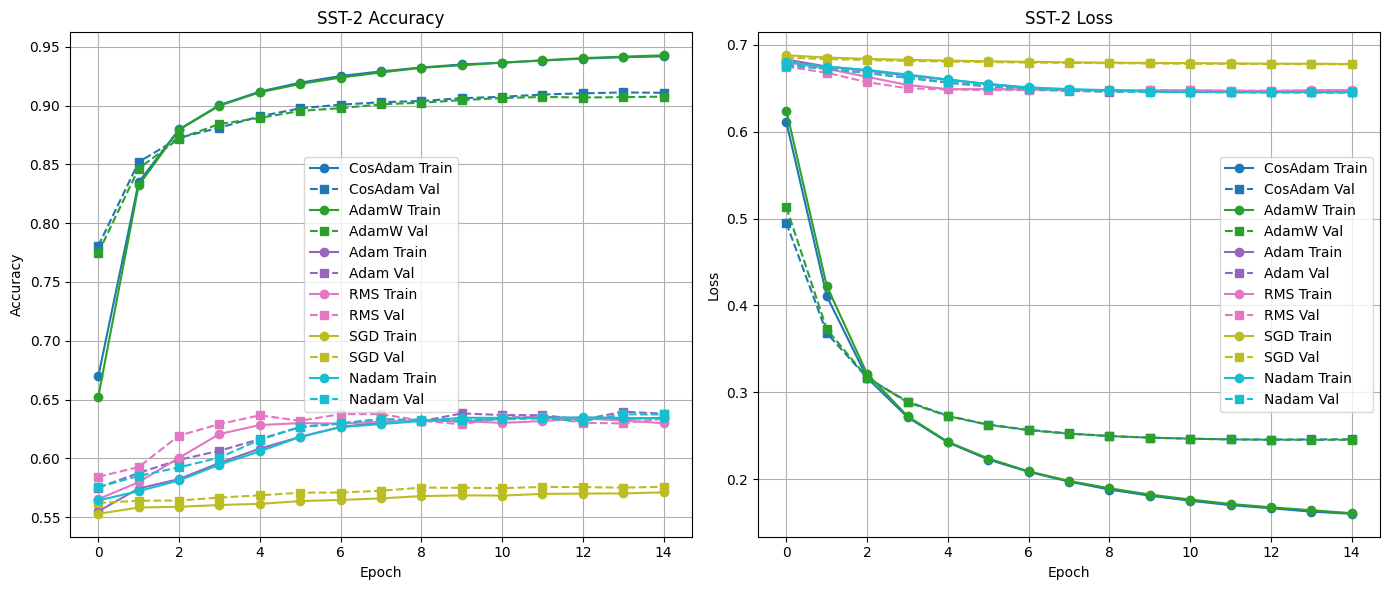

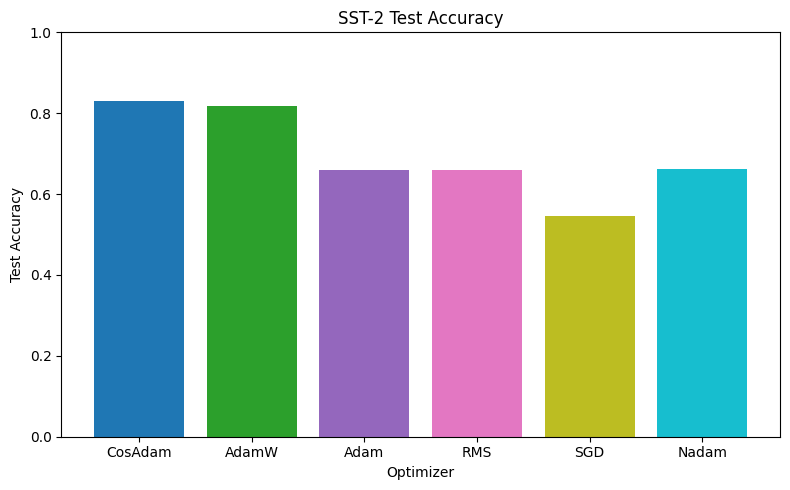

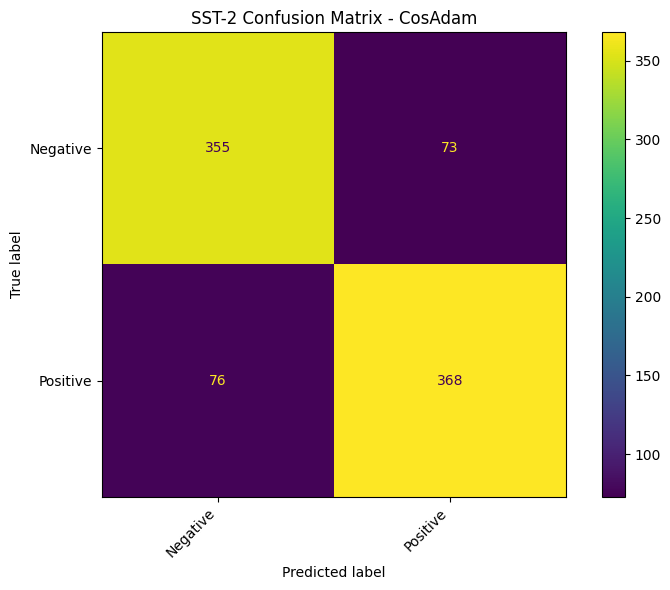

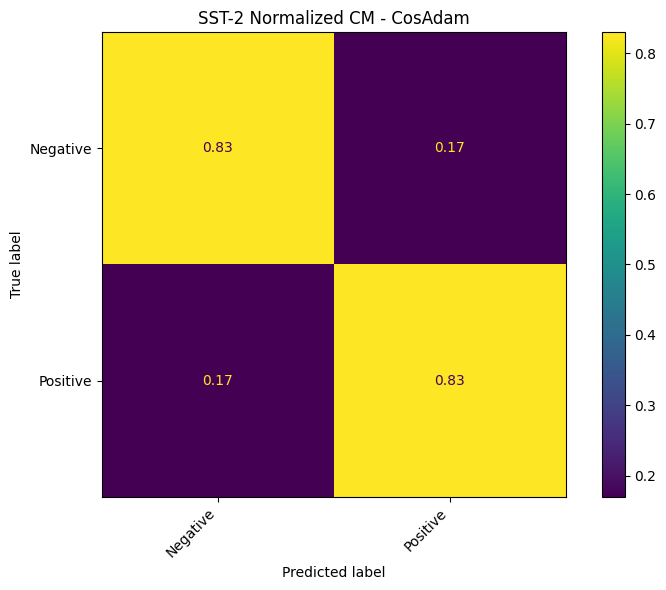

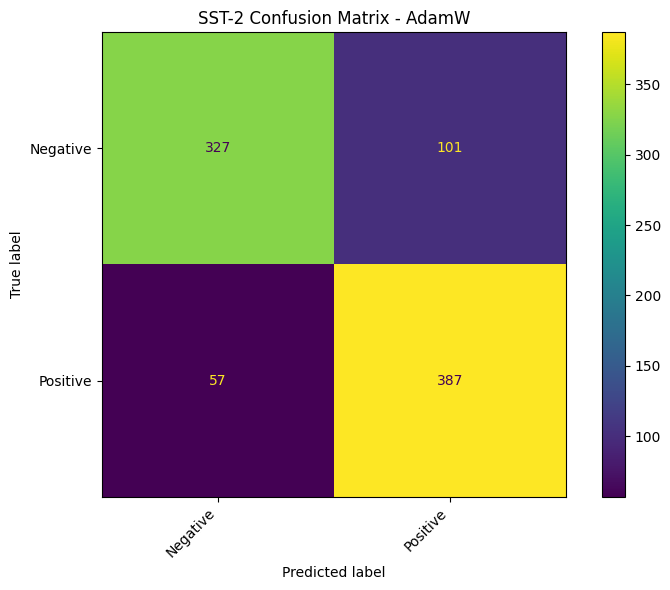

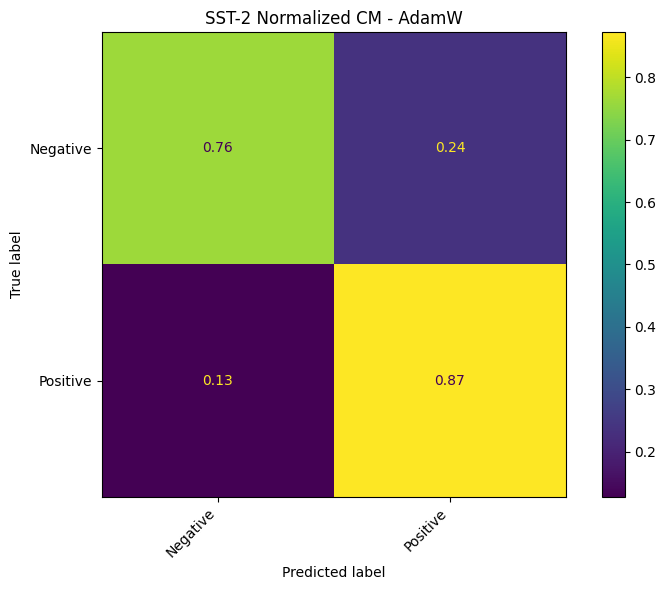

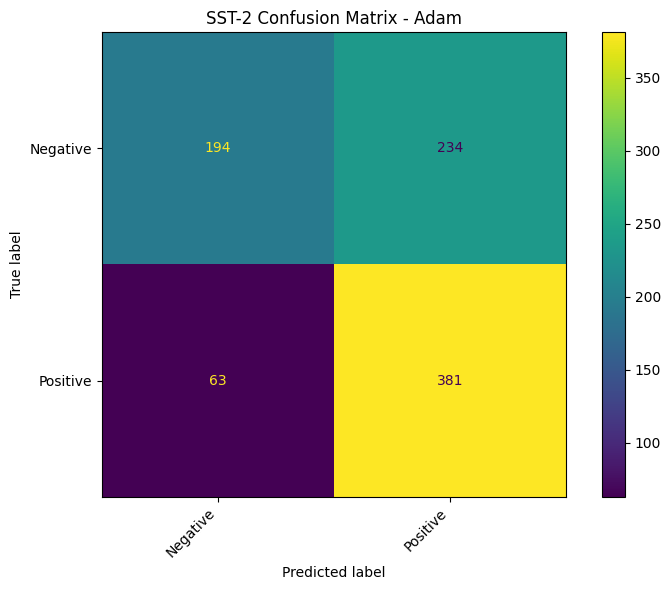

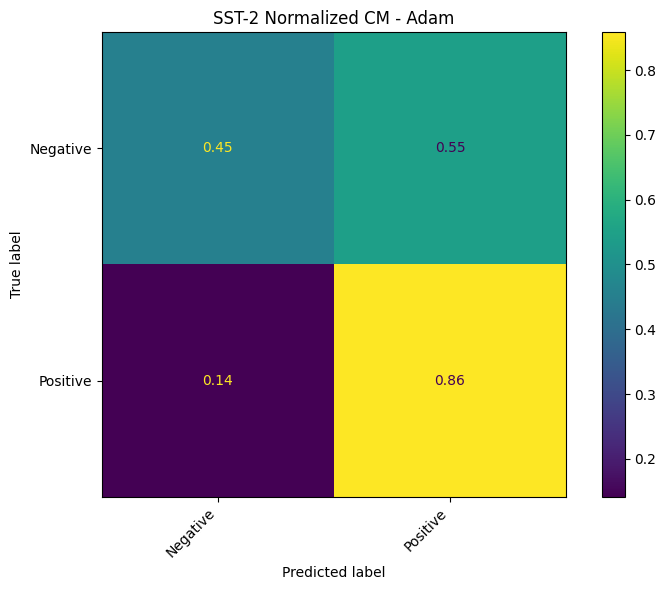

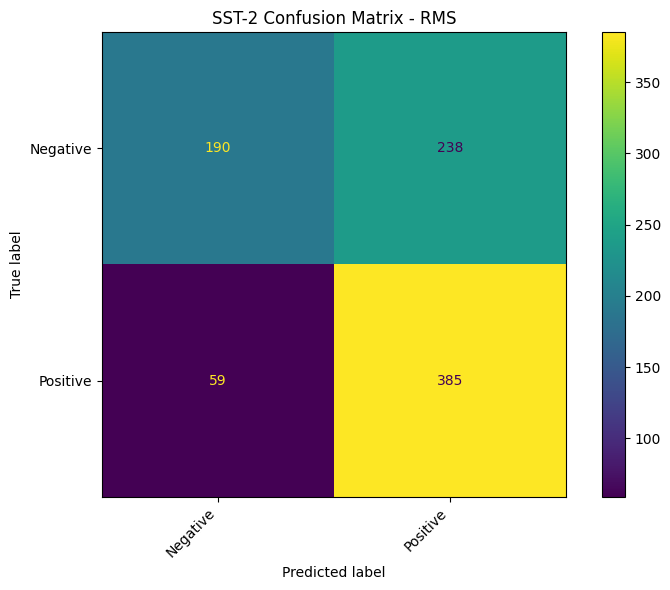

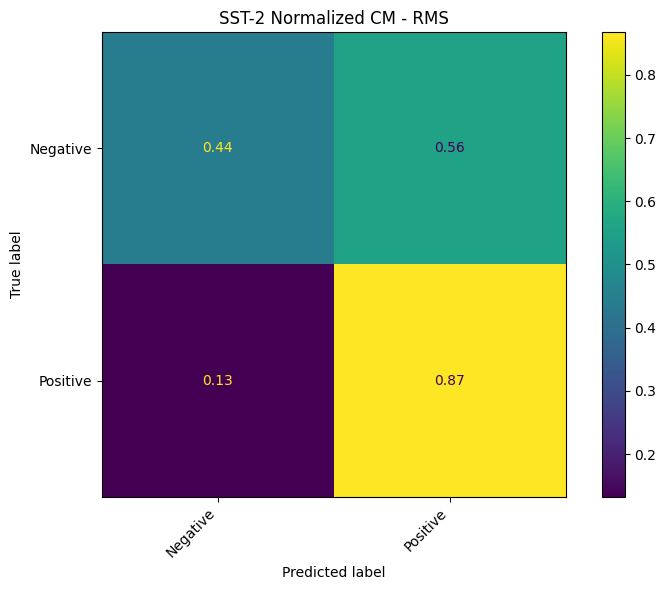

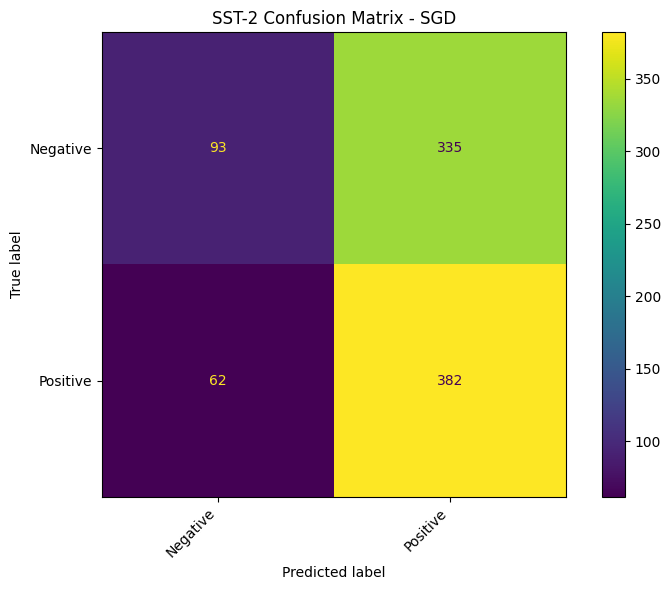

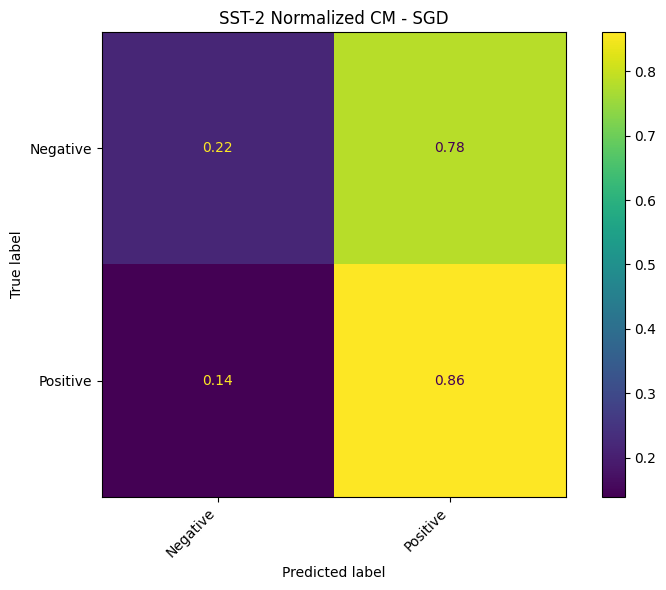

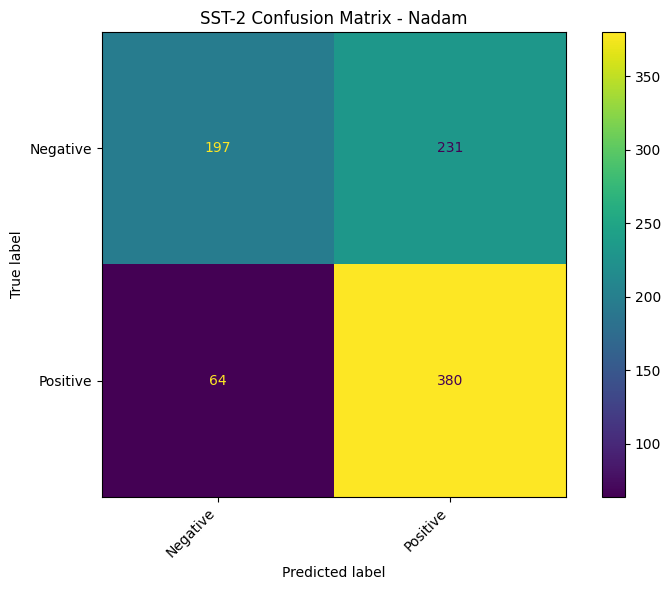

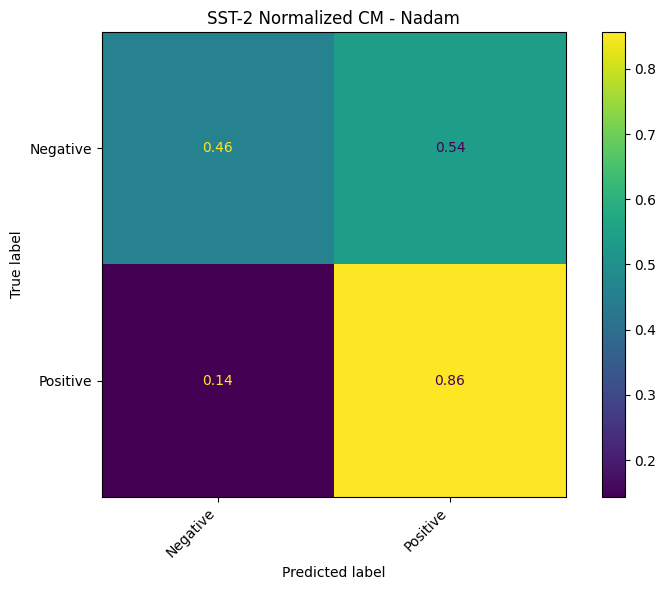

In [9]:
import os
import random
import time
from collections import Counter
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login

# Setup & Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
nltk.download('punkt', quiet=True)

# Authenticate with Hugging Face Hub (optional but recommended)
try:
    notebook_login()
except Exception as e:
    print(f"Authentication failed (optional): {e}")

num_epochs = 15



# ---------------------------
# CosAdam Optimizer (Improved Implementation)
# ---------------------------
class CosAdam(optim.Optimizer):
    """Implements CosAdam: Adam with cosine similarity-based step adjustment."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, alpha=0.9, c=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, alpha=alpha, c=c)
        super(CosAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # Initialize state
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                    state['s'] = 0.0  # Smoothed cosine similarity

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                prev_grad, s = state['prev_grad'], state['s']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Cosine similarity calculation (skip first step)
                if state['step'] > 1:
                    cos_theta = torch.cosine_similarity(grad.flatten(),
                                                       prev_grad.flatten(), dim=0)
                    s = group['alpha'] * s + (1 - group['alpha']) * cos_theta.item()
                state['s'] = s

                # Adam update components
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                denom = (exp_avg_sq.sqrt() / np.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                # Apply cosine scaling
                update = -step_size * exp_avg / denom
                update.mul_(1 + group['c'] * s)

                # Weight decay (AdamW style)
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * group['lr'])

                p.data.add_(update)
                state['prev_grad'].copy_(grad)

        return loss


# Text Classification Model for SST-2
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_class=2, pad_idx=1):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.classifier = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        emb = self.embedding(text)
        pooled = emb.mean(dim=1)
        return self.classifier(pooled)

# Data Preparation: SST-2
print("Loading SST-2...")
dataset = load_dataset("sst2")
train_raw, val_raw = random_split(dataset['train'], [int(0.9*len(dataset['train'])), len(dataset['train'])-int(0.9*len(dataset['train']))])
test_raw = dataset['validation']

counter = Counter()
for item in train_raw:
    tokens = word_tokenize(item['sentence'].lower())
    counter.update(tokens)
vocab = {'<unk>':0, '<pad>':1}
for i, tok in enumerate(counter, start=2): vocab[tok] = i
pad_idx = vocab['<pad>']
unk_idx = vocab['<unk>']

def text_pipeline(text):
    return [vocab.get(tok, unk_idx) for tok in word_tokenize(text.lower())]

class SST2Dataset(Dataset):
    def __init__(self, subset): self.subset = subset
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx): return self.subset[idx]['sentence'], self.subset[idx]['label']

def collate_batch(batch):
    texts, labels = zip(*batch)
    seqs = [torch.tensor(text_pipeline(t), dtype=torch.long) for t in texts]
    padded = pad_sequence(seqs, batch_first=True, padding_value=pad_idx)
    return padded, torch.tensor(labels, dtype=torch.long)

train_loader_sst2 = DataLoader(SST2Dataset(train_raw), batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader_sst2 = DataLoader(SST2Dataset(val_raw), batch_size=64, shuffle=False, collate_fn=collate_batch)
test_loader_sst2 = DataLoader(SST2Dataset(test_raw), batch_size=64, shuffle=False, collate_fn=collate_batch)

sst2_class_names = ['Negative', 'Positive']

# Generic Train Model Function
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader,
                num_epochs=num_epochs, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()  # Corrected from Cross-webkitLoss
    optimizer = optimizer_factory(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
        train_loss /= total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, preds = outputs.max(1)
                val_total += targets.size(0)
                val_correct += preds.eq(targets).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()

    # Test evaluation
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            test_correct += preds.eq(targets).sum().item()
            test_total += targets.size(0)
    test_loss /= test_total
    test_acc = test_correct / test_total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    history.update({
        'test_loss': test_loss, 'test_acc': test_acc,
        'precision': precision, 'recall': recall, 'f1': f1,
        'runtime': time.time() - start_time,
        'targets': all_targets, 'probs': all_probs
    })

    print(f"\nFinal Results on {dataset_name}: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    return history

# Optimizers
optimizers = {
    'CosAdam':  lambda p: CosAdam(p, lr=1e-3, weight_decay=1e-3),
    'AdamW': lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-3),
    'Adam':  lambda p: optim.Adam(p, lr=1e-3, weight_decay=1e-3),
    'RMS':   lambda p: optim.RMSprop(p, lr=1e-3, weight_decay=1e-3),
    'SGD':   lambda p: optim.SGD(p, lr=1e-3, momentum=0.9, weight_decay=1e-3),
    'Nadam': lambda p: optim.NAdam(p, lr=1e-3, weight_decay=1e-3),
}

# Run Experiments for SST-2
results_sst2 = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- SST-2: Training with {opt_name} ---')
    results_sst2[opt_name] = train_model(
        lambda: TextClassificationModel(len(vocab), 64, 2, pad_idx),
        opt_factory,
        train_loader_sst2,
        val_loader_sst2,
        test_loader_sst2,
        num_epochs=num_epochs,
        dataset_name="SST-2"
    )

# Plotting Functions
def plot_learning_curves(results, dataset_name, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    for idx, opt in enumerate(results):
        axes[0].plot(results[opt]['train_acc'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[0].plot(results[opt]['val_acc'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[0].set_title(f'{dataset_name} Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    for idx, opt in enumerate(results):
        axes[1].plot(results[opt]['train_loss'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[1].plot(results[opt]['val_loss'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[1].set_title(f'{dataset_name} Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_learning_curves.png')

def plot_test_accuracy(results, dataset_name):
    final_acc = {opt: results[opt]['test_acc'] for opt in results}
    colors = plt.cm.tab10(np.linspace(0, 1, len(final_acc)))
    plt.figure(figsize=(8, 5))
    plt.bar(final_acc.keys(), final_acc.values(), color=colors)
    plt.ylim(0, 1)
    plt.title(f'{dataset_name} Test Accuracy')
    plt.xlabel('Optimizer')
    plt.ylabel('Test Accuracy')
    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_test_accuracy.png')

def plot_roc_curves(results, dataset_name, class_names):
    for opt in results:
        all_targets = results[opt]['targets']
        y_score = np.array(results[opt]['probs'])
        if len(class_names) == 2:
            # Binary classification: single ROC curve for positive class
            fpr, tpr, _ = roc_curve(all_targets, y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{dataset_name} ROC Curve - {opt}')
            plt.legend()
            # plt.savefig(f'{dataset_name.lower()}_roc_{opt}.png')
            plt.close()
        else:
            # Multi-class classification: ROC curve per class
            y_true = label_binarize(all_targets, classes=range(len(class_names)))
            fpr, tpr, roc_auc = {}, {}, {}
            for i in range(len(class_names)):
                fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            plt.figure()
            for i in range(len(class_names)):
                plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{dataset_name} ROC Curves - {opt}')
            plt.legend()
            # plt.savefig(f'{dataset_name.lower()}_roc_{opt}.png')
            plt.close()

def plot_confusion_matrix(cm, class_names, title, normalize=False, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
        values_format = '.2f'
    else:
        values_format = 'd'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', ax=ax, values_format=values_format)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path)

# Generate Plots for SST-2
plot_learning_curves(results_sst2, "SST-2", sst2_class_names)
plot_test_accuracy(results_sst2, "SST-2")
plot_roc_curves(results_sst2, "SST-2", sst2_class_names)
for opt in results_sst2:
    cm = confusion_matrix(results_sst2[opt]['targets'], np.argmax(results_sst2[opt]['probs'], axis=1))
    plot_confusion_matrix(cm, sst2_class_names, f'SST-2 Confusion Matrix - {opt}', save_path=f'sst2_cm_{opt}.png')
    plot_confusion_matrix(cm, sst2_class_names, f'SST-2 Normalized CM - {opt}', normalize=True, save_path=f'sst2_cm_normalized_{opt}.png')

# LaTeX Table Generation
def generate_latex_table(results, dataset_name):
    table = (
        "\\begin{table}[H]\n"
        "\\centering\n"
        "\\begin{tabular}{lcccccc}\\toprule\n"
        "Optimizer & Test Loss & Test Acc & Precision & Recall & F1 & Epoch Time (s) \\\\ \\midrule\n"
    )
    for opt, m in results.items():
        epoch_time = m['runtime'] / num_epochs  # Calculate per-epoch time
        table += (
            f"{opt} & {m['test_loss']:.4f} & {m['test_acc']:.4f} & "
            f"{m['precision']:.4f} & {m['recall']:.4f} & {m['f1']:.4f} & "
            f"{epoch_time:.2f} \\\\\n"
        )
    table += (
        "\\bottomrule\n"
        "\\end{tabular}\n"
        f"\\caption{{Performance Metrics for {dataset_name}}}\n"
        f"\\label{{tab:{dataset_name.lower()}_perf}}\n"
        "\\end{table}\n"
    )
    return table

# Print LaTeX Table for SST-2
print("\n=== LaTeX Table for SST-2 ===\n", generate_latex_table(results_sst2, "SST-2"))

# NOISY MNIST


--- MNIST Noisy: Training with CosAdam ---
Epoch 1/7 - Train Loss: 0.5636, Train Acc: 0.8169, Val Loss: 0.2102, Val Acc: 0.9336
Epoch 2/7 - Train Loss: 0.2216, Train Acc: 0.9305, Val Loss: 0.1680, Val Acc: 0.9484
Epoch 3/7 - Train Loss: 0.1781, Train Acc: 0.9433, Val Loss: 0.1508, Val Acc: 0.9538
Epoch 4/7 - Train Loss: 0.1640, Train Acc: 0.9476, Val Loss: 0.1387, Val Acc: 0.9548
Epoch 5/7 - Train Loss: 0.1503, Train Acc: 0.9517, Val Loss: 0.1273, Val Acc: 0.9590
Epoch 6/7 - Train Loss: 0.1417, Train Acc: 0.9536, Val Loss: 0.1190, Val Acc: 0.9642
Epoch 7/7 - Train Loss: 0.1360, Train Acc: 0.9564, Val Loss: 0.1281, Val Acc: 0.9584

Final Results on MNIST_Noisy: Test Loss: 0.1042, Test Acc: 0.9664, Precision: 0.9661, Recall: 0.9663, F1: 0.9661


--- MNIST Noisy: Training with AdamW ---
Epoch 1/7 - Train Loss: 0.6293, Train Acc: 0.7938, Val Loss: 0.2576, Val Acc: 0.9162
Epoch 2/7 - Train Loss: 0.2450, Train Acc: 0.9224, Val Loss: 0.1981, Val Acc: 0.9342
Epoch 3/7 - Train Loss: 0.2047, Tr

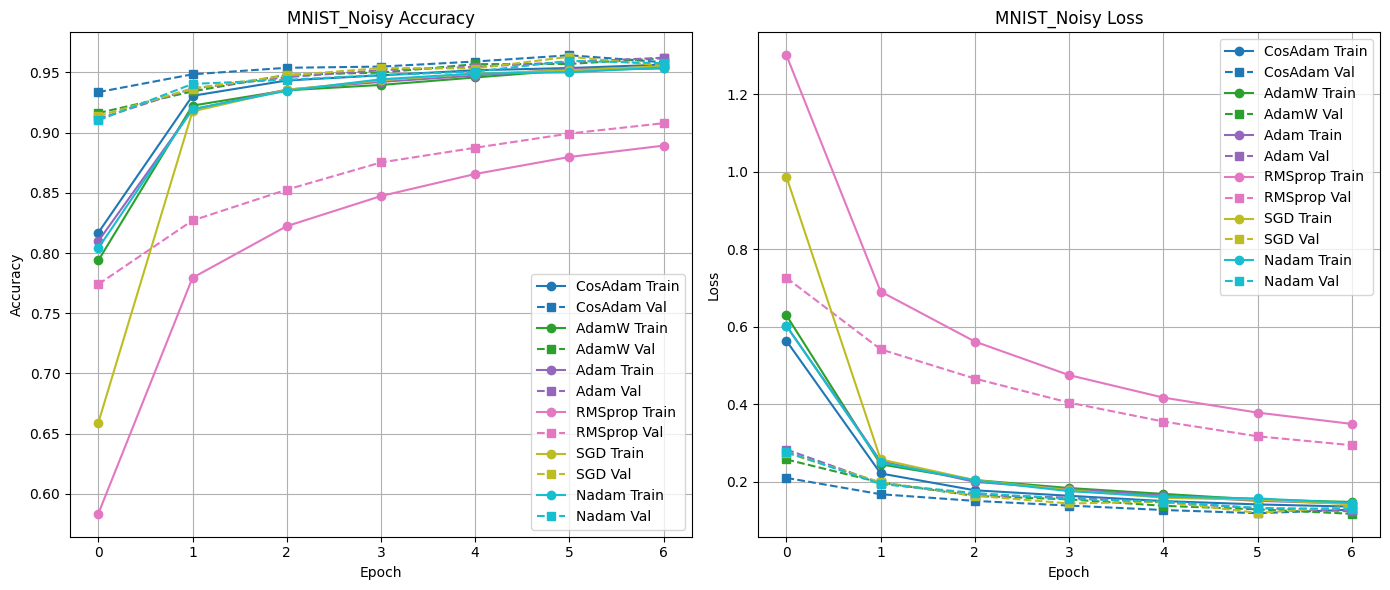

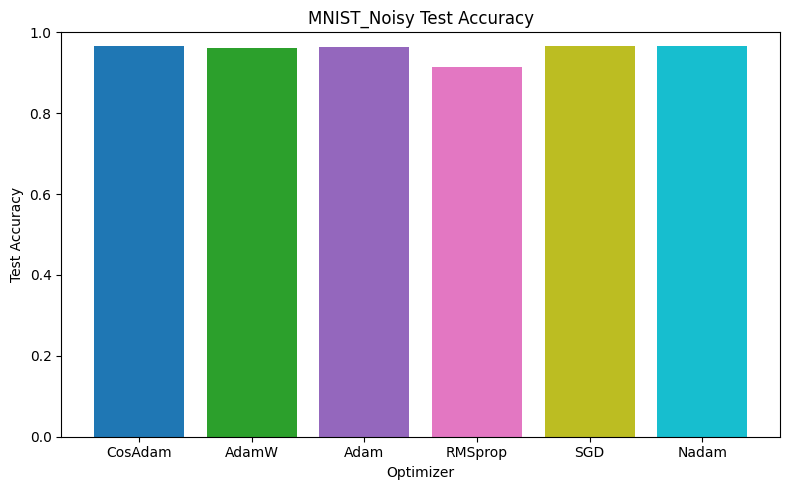

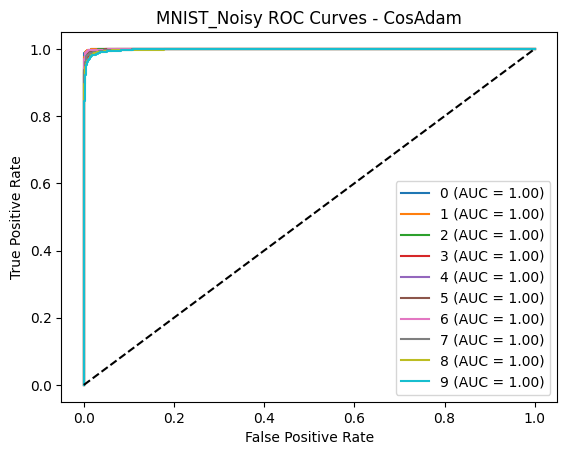

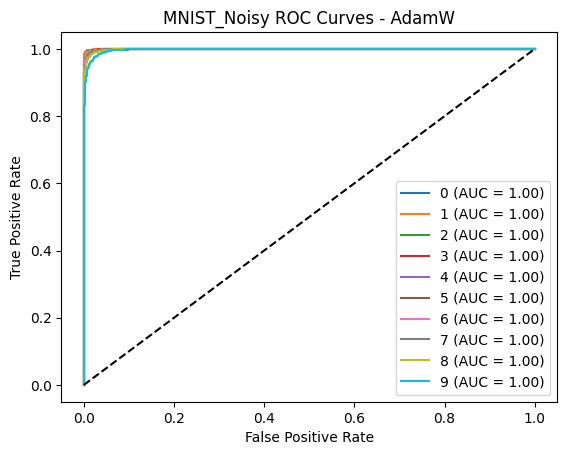

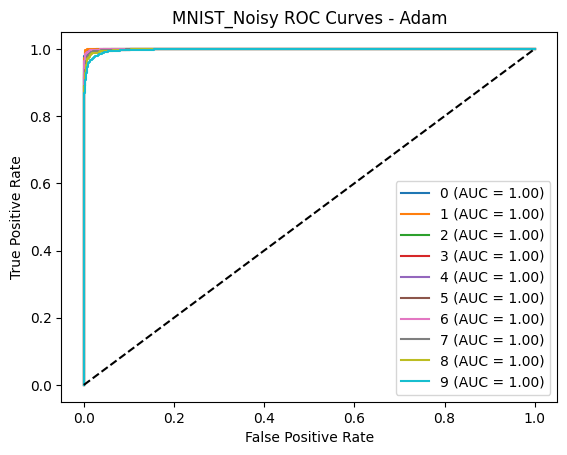

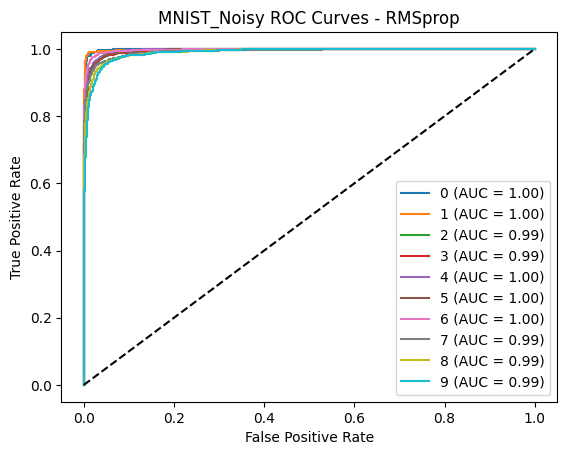

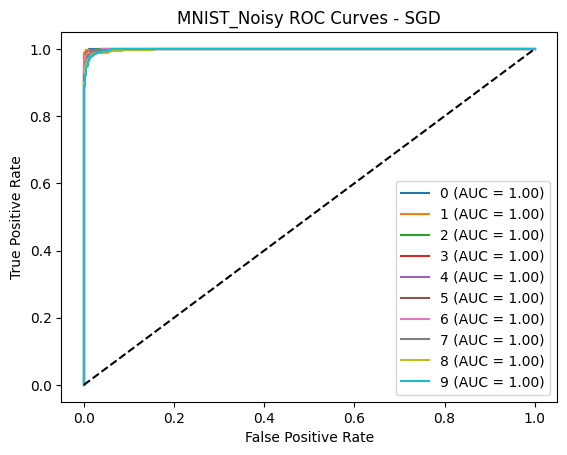

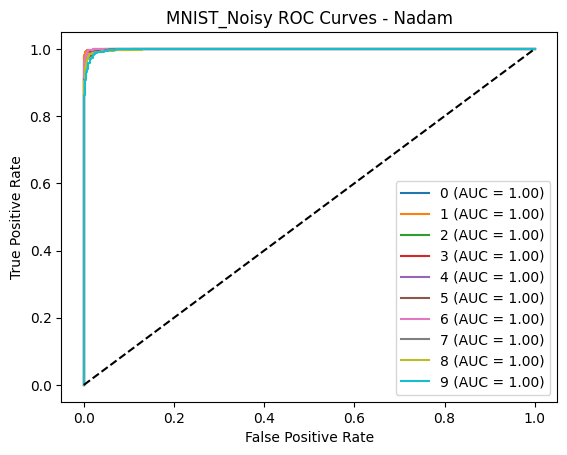

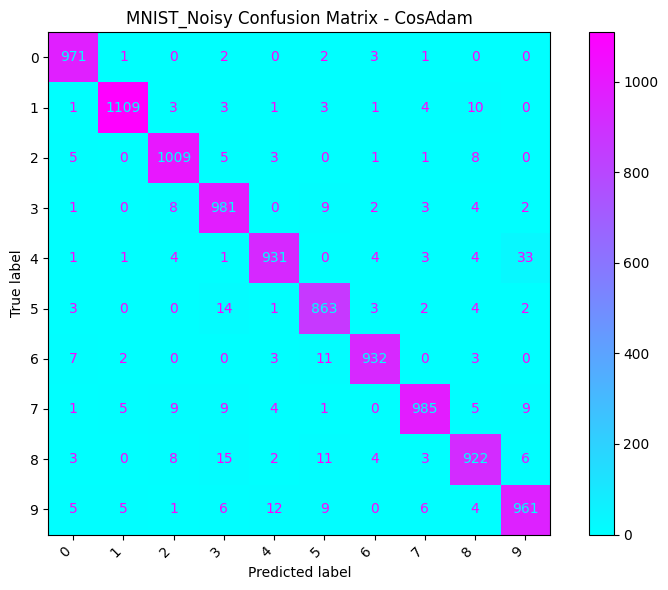

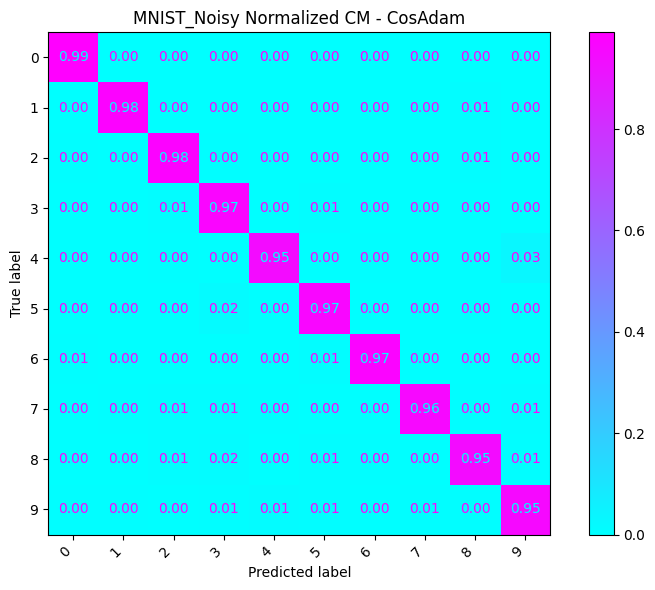

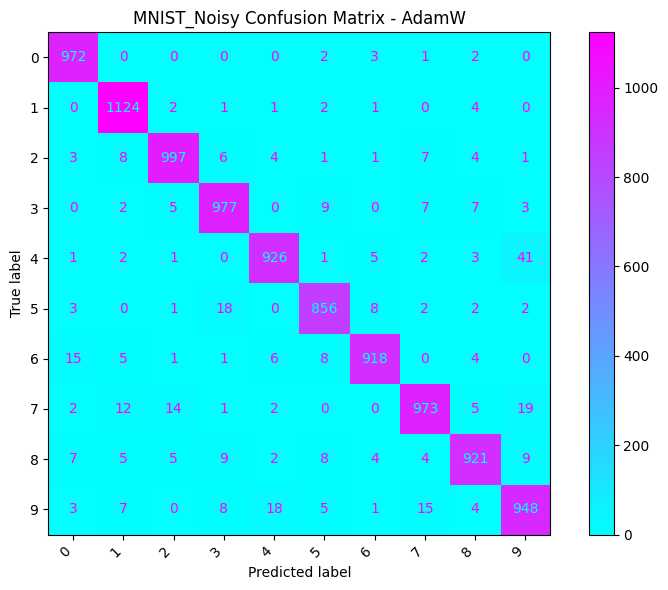

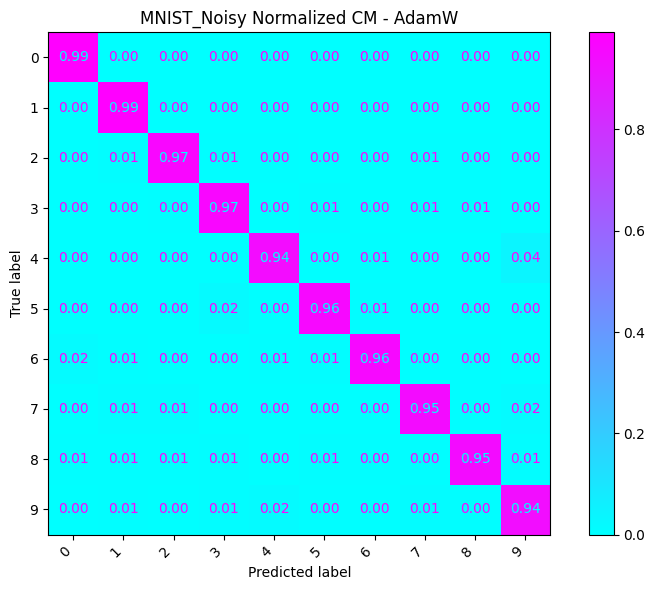

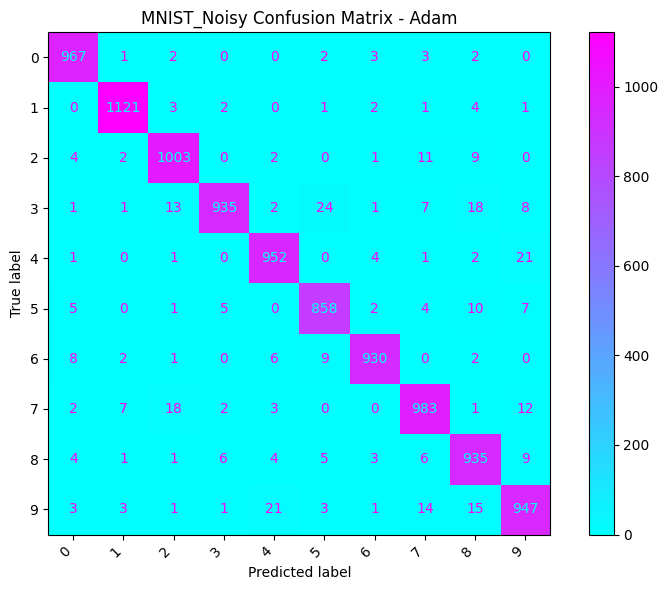

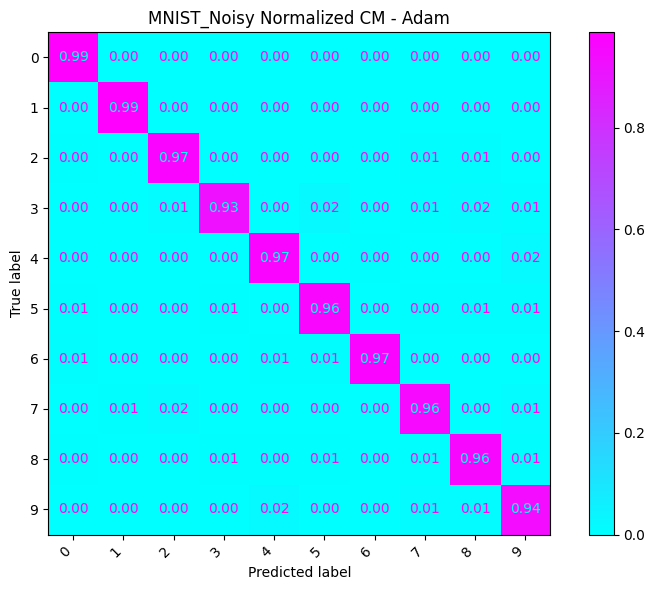

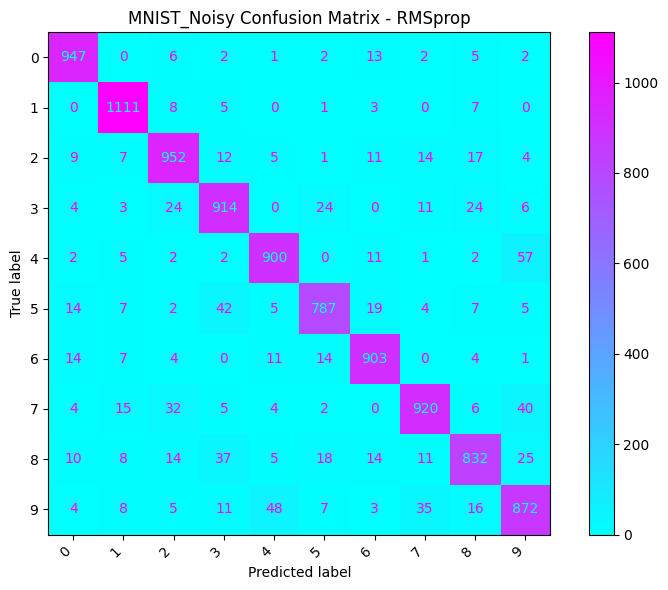

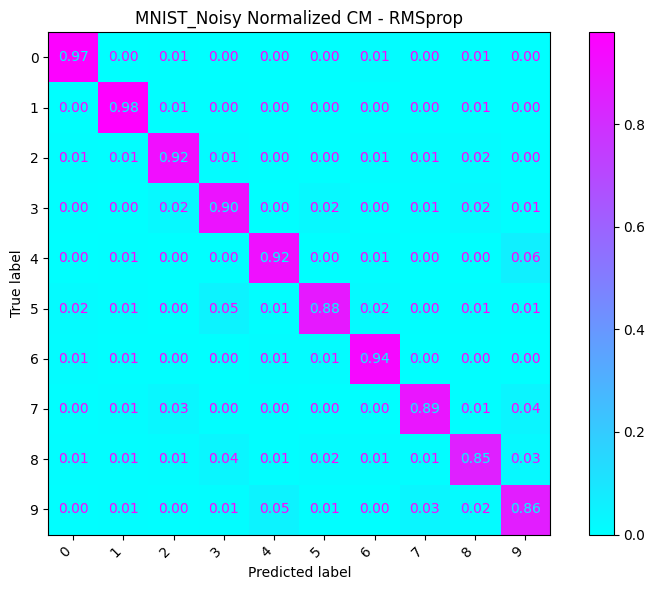

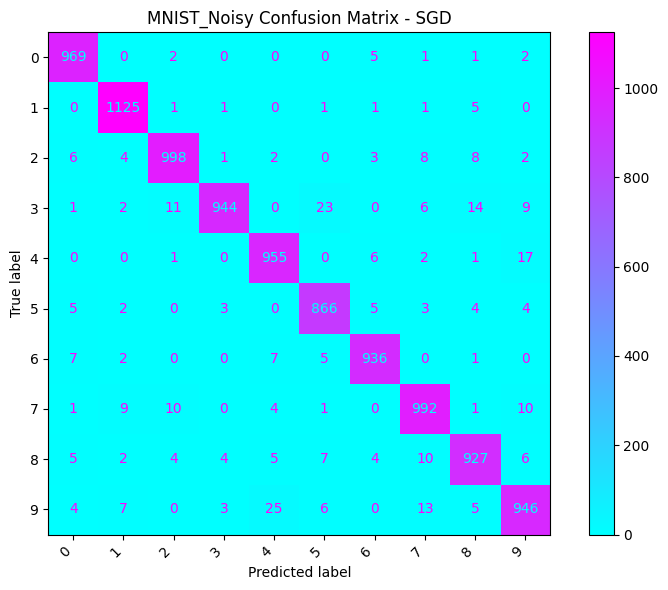

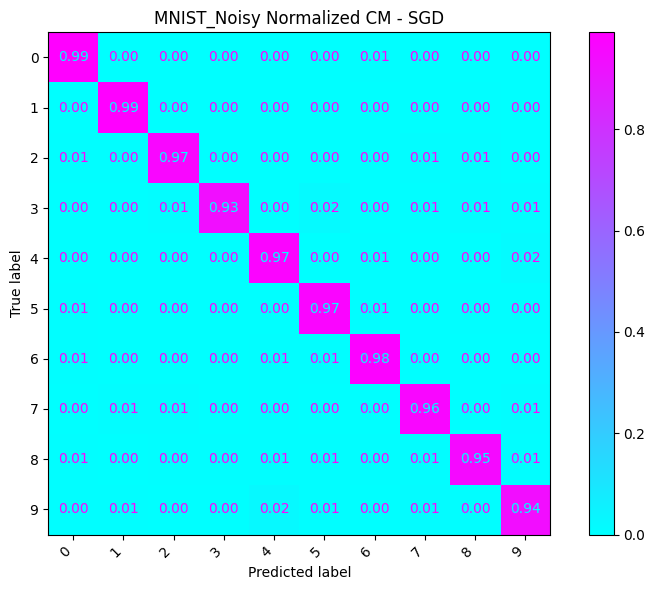

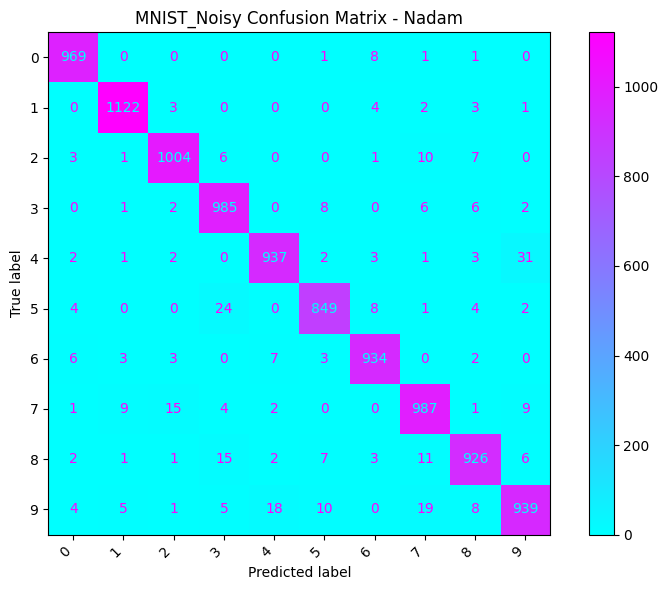

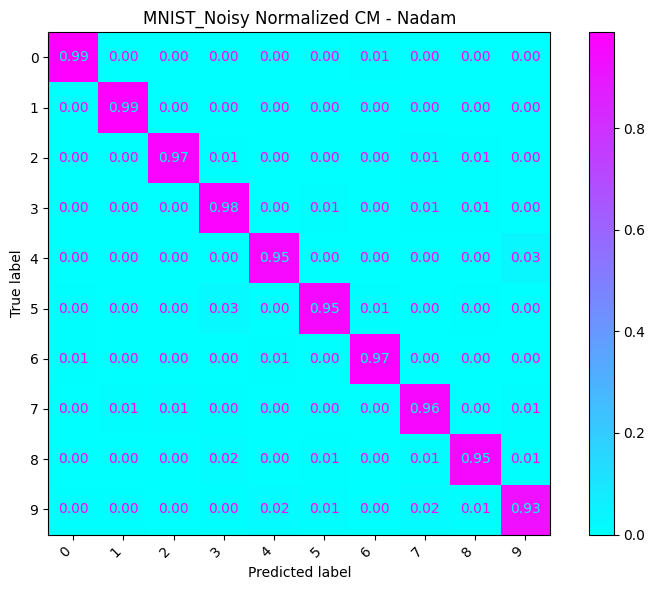

In [ ]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import math

# Setup & Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

num_epochs = 7

# ---------------------------
# CosAdam Optimizer 
# ---------------------------
class CosAdam(optim.Optimizer):
    """Implements CosAdam: Adam with cosine similarity-based step adjustment."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, alpha=0.9, c=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, alpha=alpha, c=c)
        super(CosAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # Initialize state
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                    state['s'] = 0.0  # Smoothed cosine similarity

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                prev_grad, s = state['prev_grad'], state['s']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Cosine similarity calculation (skip first step)
                if state['step'] > 1:
                    cos_theta = torch.cosine_similarity(grad.flatten(),
                                                       prev_grad.flatten(), dim=0)
                    s = group['alpha'] * s + (1 - group['alpha']) * cos_theta.item()
                state['s'] = s

                # Adam update components
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                # Apply cosine scaling
                update = -step_size * exp_avg / denom
                update.mul_(1 + group['c'] * s)

                # Weight decay (AdamW style)
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * group['lr'])

                p.data.add_(update)
                state['prev_grad'].copy_(grad)

        return loss


# LeNet-5 Model for MNIST
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data Preparation: Noisy MNIST
noise_std = 0.5

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(noisy, 0., 1.)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., noise_std),
    transforms.Normalize((0.1307,), (0.3081,)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., noise_std),
    transforms.Normalize((0.1307,), (0.3081,)),
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
train_set, val_set = random_split(mnist_train, [55000, 5000])

train_loader_mnist = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
test_loader_mnist = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=2)

mnist_class_names = [str(i) for i in range(10)]

# Generic Train Model Function
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader,
                num_epochs=num_epochs, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
        train_loss /= total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, preds = outputs.max(1)
                val_total += targets.size(0)
                val_correct += preds.eq(targets).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()

    # Test evaluation
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, preds = outputs.max(1)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            test_correct += preds.eq(targets).sum().item()
            test_total += targets.size(0)
    test_loss /= test_total
    test_acc = test_correct / test_total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    history.update({
        'test_loss': test_loss, 'test_acc': test_acc,
        'precision': precision, 'recall': recall, 'f1': f1,
        'runtime': time.time() - start_time,
        'targets': all_targets, 'probs': all_probs
    })

    print(f"\nFinal Results on {dataset_name}: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    return history


# Optimizers with tuned learning rates
optimizers = {
    'CosAdam':  lambda p: CosAdam(p, lr=1e-3, weight_decay=1e-3),
    'AdamW': lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-3),
    'Adam':  lambda p: optim.Adam(p, lr=1e-3, weight_decay=1e-3),
    'RMSprop': lambda p: optim.RMSprop(p, lr=1e-4, weight_decay=1e-3),  # Adjusted learning rate
    'SGD':   lambda p: optim.SGD(p, lr=1e-2, momentum=0.9, weight_decay=1e-3),  # Adjusted learning rate
    'Nadam': lambda p: optim.NAdam(p, lr=1e-3, weight_decay=1e-3),
}


# Run Experiments for MNIST Noisy
results_mnist_noisy = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- MNIST Noisy: Training with {opt_name} ---')
    results_mnist_noisy[opt_name] = train_model(
        LeNet5,
        opt_factory,
        train_loader_mnist,
        val_loader_mnist,
        test_loader_mnist,
        num_epochs=num_epochs,
        dataset_name="MNIST_Noisy"
    )

# Plotting Functions
def plot_learning_curves(results, dataset_name, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    for idx, opt in enumerate(results):
        axes[0].plot(results[opt]['train_acc'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[0].plot(results[opt]['val_acc'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[0].set_title(f'{dataset_name} Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    for idx, opt in enumerate(results):
        axes[1].plot(results[opt]['train_loss'], marker='o', color=colors[idx], linestyle='-', label=f'{opt} Train')
        axes[1].plot(results[opt]['val_loss'], marker='s', color=colors[idx], linestyle='--', label=f'{opt} Val')
    axes[1].set_title(f'{dataset_name} Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_learning_curves.png')

def plot_test_accuracy(results, dataset_name):
    final_acc = {opt: results[opt]['test_acc'] for opt in results}
    colors = plt.cm.tab10(np.linspace(0, 1, len(final_acc)))
    plt.figure(figsize=(8, 5))
    plt.bar(final_acc.keys(), final_acc.values(), color=colors)
    plt.ylim(0, 1)
    plt.title(f'{dataset_name} Test Accuracy')
    plt.xlabel('Optimizer')
    plt.ylabel('Test Accuracy')
    plt.tight_layout()
    # plt.savefig(f'{dataset_name.lower()}_test_accuracy.png')

def plot_roc_curves(results, dataset_name, class_names):
    for opt in results:
        y_true = label_binarize(results[opt]['targets'], classes=range(len(class_names)))
        y_score = np.array(results[opt]['probs'])
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure()
        for i in range(len(class_names)):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{dataset_name} ROC Curves - {opt}')
        plt.legend()
        # plt.savefig(f'{dataset_name.lower()}_roc_{opt}.png')

def plot_confusion_matrix(cm, class_names, title, normalize=False, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
        values_format = '.2f'
    else:
        values_format = 'd'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='cool', ax=ax, values_format=values_format)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path)

# Generate Plots for MNIST Noisy
plot_learning_curves(results_mnist_noisy, "MNIST_Noisy", mnist_class_names)
plot_test_accuracy(results_mnist_noisy, "MNIST_Noisy")
plot_roc_curves(results_mnist_noisy, "MNIST_Noisy", mnist_class_names)
for opt in results_mnist_noisy:
    cm = confusion_matrix(results_mnist_noisy[opt]['targets'], np.argmax(results_mnist_noisy[opt]['probs'], axis=1))
    plot_confusion_matrix(cm, mnist_class_names, f'MNIST_Noisy Confusion Matrix - {opt}', save_path=f'mnist_noisy_cm_{opt}.png')
    plot_confusion_matrix(cm, mnist_class_names, f'MNIST_Noisy Normalized CM - {opt}', normalize=True, save_path=f'mnist_noisy_cm_normalized_{opt}.png')

# LaTeX Table Generation
def generate_latex_table(results, dataset_name):
    table = (
        "\\begin{table}[H]\n"
        "\\centering\n"
        "\\begin{tabular}{lcccccc}\\toprule\n"
        "Optimizer & Test Loss & Test Acc & Precision & Recall & F1 & Epoch Time (s) \\\\ \\midrule\n"
    )
    for opt, m in results.items():
        epoch_time = m['runtime'] / 15  # Assuming 15 epochs
        table += (
            f"{opt} & {m['test_loss']:.4f} & {m['test_acc']:.4f} & "
            f"{m['precision']:.4f} & {m['recall']:.4f} & {m['f1']:.4f} & "
            f"{epoch_time:.2f} \\\\\n"
        )
    table += (
        "\\bottomrule\n"
        "\\end{tabular}\n"
        f"\\caption{{Performance Metrics for {dataset_name}}}\n"
        f"\\label{{tab:{dataset_name.lower()}_perf}}\n"
        "\\end{table}\n"
    )
    return table

# Print LaTeX Table for MNIST Noisy
print("\n=== LaTeX Table for MNIST_Noisy ===\n", generate_latex_table(results_mnist_noisy, "MNIST_Noisy"))

# Combination


--- MNIST: Training with DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5 ---

Training on MNIST_DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5 for 15 epochs...
Epoch 1 (MNIST_DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5) => Train Loss: 0.3360, Train Acc: 0.8965 | Val Loss: 0.0918, Val Acc: 0.9722 | Time: 13.47 sec
Epoch 2 (MNIST_DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5) => Train Loss: 0.0891, Train Acc: 0.9720 | Val Loss: 0.0876, Val Acc: 0.9744 | Time: 15.45 sec
Epoch 3 (MNIST_DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5) => Train Loss: 0.0653, Train Acc: 0.9796 | Val Loss: 0.0684, Val Acc: 0.9808 | Time: 14.19 sec
Epoch 4 (MNIST_DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5) => Train Loss: 0.0526, Train Acc: 0.9833 | Val Loss: 0.0554, Val Acc: 0.9852 | Time: 14.00 sec
Epoch 5 (MNIST_DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5) => Train Loss: 0.0447, Train Acc: 0.9867 | Val Loss: 0.0480, Val Acc: 0.9850 | Time: 13.60 sec
Epoch 6 

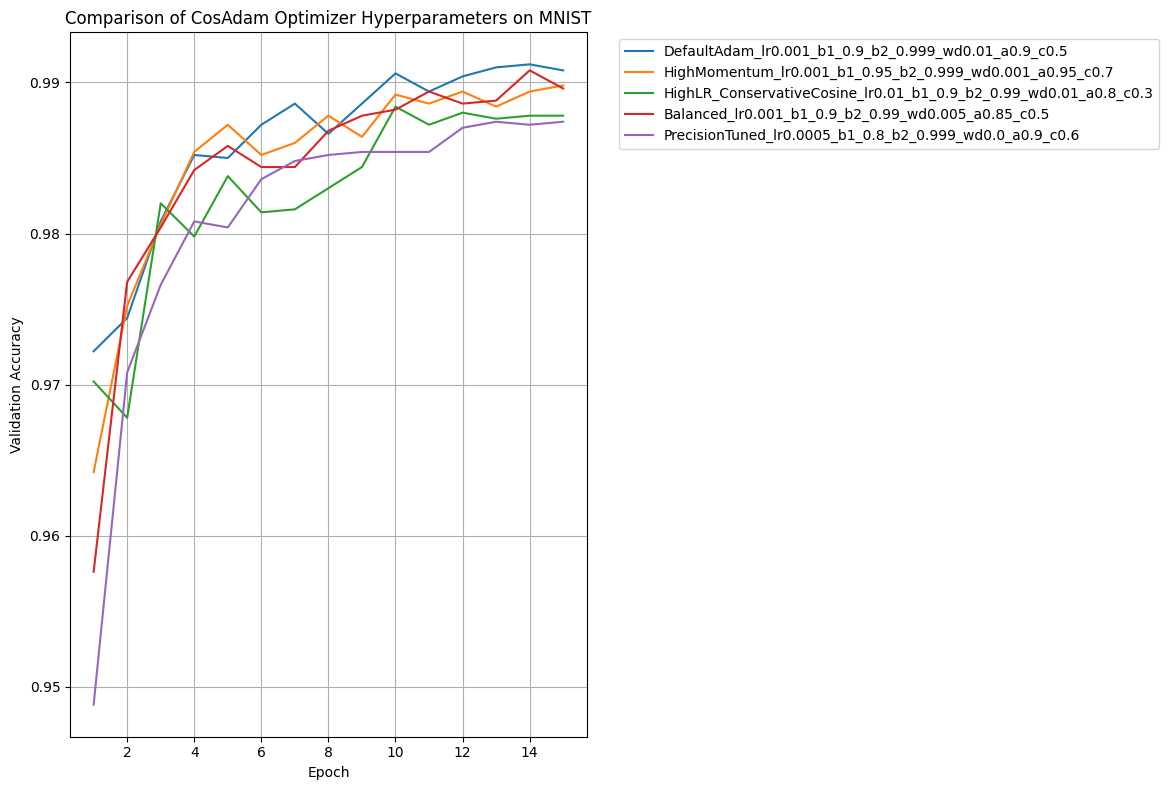

In [ ]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Reproducibility: Seed Initialization
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

epochs = 15

# ---------------------------
# CosAdam Optimizer 
# ---------------------------
class CosAdam(optim.Optimizer):
    """Implements CosAdam: Adam with cosine similarity-based step adjustment."""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, alpha=0.9, c=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, alpha=alpha, c=c)
        super(CosAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # Initialize state
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                    state['s'] = 0.0  # Smoothed cosine similarity

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                prev_grad, s = state['prev_grad'], state['s']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Cosine similarity calculation (skip first step)
                if state['step'] > 1:
                    cos_theta = torch.cosine_similarity(grad.flatten(),
                                                       prev_grad.flatten(), dim=0)
                    s = group['alpha'] * s + (1 - group['alpha']) * cos_theta.item()
                state['s'] = s

                # Adam update components
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                # Apply cosine scaling
                update = -step_size * exp_avg / denom
                update.mul_(1 + group['c'] * s)

                # Weight decay (AdamW style)
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * group['lr'])

                p.data.add_(update)
                state['prev_grad'].copy_(grad)

        return loss

# MNIST: LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data Preparation for MNIST
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
train_size_mnist, val_size_mnist = 55000, 5000
trainset_mnist, valset_mnist = random_split(trainset_mnist, [train_size_mnist, val_size_mnist])
train_loader_mnist = DataLoader(trainset_mnist, batch_size=128, shuffle=True, num_workers=2)
val_loader_mnist = DataLoader(valset_mnist, batch_size=128, shuffle=False, num_workers=2)
test_loader_mnist = DataLoader(testset_mnist, batch_size=128, shuffle=False, num_workers=2)

# Training Function
def train_model(model_fn, optimizer_factory, train_loader, val_loader, test_loader, num_epochs=3, dataset_name="Dataset"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_factory(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    writer = SummaryWriter(log_dir=f"runs/{dataset_name}_{model_fn.__name__}")

    overall_start_time = time.time()

    metrics = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'test_loss': 0.0, 'test_acc': 0.0,
        'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0,
        'probs': [], 'targets': [],
        'total_time': 0.0
    }

    print(f"\nTraining on {dataset_name} for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct / total
        metrics['train_loss'].append(epoch_train_loss)
        metrics['train_acc'].append(epoch_train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        metrics['val_loss'].append(epoch_val_loss)
        metrics['val_acc'].append(epoch_val_acc)

        writer.add_scalar(f"{dataset_name}/Train Loss", epoch_train_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Train Accuracy", epoch_train_acc, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Loss", epoch_val_loss, epoch)
        writer.add_scalar(f"{dataset_name}/Validation Accuracy", epoch_val_acc, epoch)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} ({dataset_name}) => Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} | Time: {epoch_time:.2f} sec")

        scheduler.step()

    total_training_time = time.time() - overall_start_time
    metrics['total_time'] = total_training_time

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    probs, targets_all = [], []
    with torch.no_grad():
        for data, t in test_loader:
            data, t = data.to(device), t.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, t).item()
            _, predicted = outputs.max(1)
            total += t.size(0)
            correct += predicted.eq(t).sum().item()
            probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            targets_all.extend(t.cpu().numpy())
    metrics['test_loss'] = test_loss / len(test_loader)
    metrics['test_acc'] = correct / total
    metrics['probs'] = np.array(probs)
    metrics['targets'] = np.array(targets_all)

    preds = np.argmax(metrics['probs'], axis=1)
    precision = precision_score(metrics['targets'], preds, average='macro')
    recall = recall_score(metrics['targets'], preds, average='macro')
    accuracy = accuracy_score(metrics['targets'], preds)
    f1 = f1_score(metrics['targets'], preds, average='macro')
    metrics['test_precision'] = precision
    metrics['test_recall'] = recall
    metrics['test_acc'] = accuracy
    metrics['test_f1'] = f1

    print(f"\nFinal Test Results on {dataset_name}:")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}")
    print(f"Total Training Time: {total_training_time:.2f} seconds\n")

    writer.close()
    return metrics, optimizer.defaults['lr'], optimizer.defaults['betas'][0], optimizer.defaults['betas'][1], optimizer.defaults['weight_decay']


# Define 5 Key Combinations of Hyperparameters for CosAdam Optimizer
optimizers = {
    # Default Adam-like configuration (baseline)
    'DefaultAdam_lr0.001_b1_0.9_b2_0.999_wd0.01_a0.9_c0.5':
        lambda params: CosAdam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, alpha=0.9, c=0.5),

    # Higher momentum with stronger cosine adjustment
    'HighMomentum_lr0.001_b1_0.95_b2_0.999_wd0.001_a0.95_c0.7':
        lambda params: CosAdam(params, lr=0.001, betas=(0.95, 0.999), weight_decay=0.001, alpha=0.95, c=0.7),

    # Aggressive learning with conservative cosine
    'HighLR_ConservativeCosine_lr0.01_b1_0.9_b2_0.99_wd0.01_a0.8_c0.3':
        lambda params: CosAdam(params, lr=0.01, betas=(0.9, 0.99), weight_decay=0.01, alpha=0.8, c=0.3),

    # Balanced configuration with medium weight decay
    'Balanced_lr0.001_b1_0.9_b2_0.99_wd0.005_a0.85_c0.5':
        lambda params: CosAdam(params, lr=0.001, betas=(0.9, 0.99), weight_decay=0.005, alpha=0.85, c=0.5),

    # Low momentum with strong gradient alignment
    'PrecisionTuned_lr0.0005_b1_0.8_b2_0.999_wd0.0_a0.9_c0.6':
        lambda params: CosAdam(params, lr=0.0005, betas=(0.8, 0.999), weight_decay=0.0, alpha=0.9, c=0.6)
}

# Run Experiments for MNIST (LeNet-5)
results_mnist = {}
hyperparameters = {}
for opt_name, opt_factory in optimizers.items():
    print(f'\n--- MNIST: Training with {opt_name} ---')
    metrics, lr, beta1, beta2, wd = train_model(
        LeNet5, opt_factory,
        train_loader_mnist, val_loader_mnist, test_loader_mnist,
        num_epochs=epochs, dataset_name=f"MNIST_{opt_name}"
    )
    results_mnist[opt_name] = metrics
    hyperparameters[opt_name] = (lr, beta1, beta2, wd)

# Plot Validation Accuracy for All Combinations
plt.figure(figsize=(12, 8))
for opt_name, metrics in results_mnist.items():
    plt.plot(range(1, epochs + 1), metrics['val_acc'], label=opt_name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of CosAdam Optimizer Hyperparameters on MNIST')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('CosAdam_mnist_comparison.png', dpi=300)

# Generate LaTeX Table
latex_table = """
\\begin{table}[h]
\\centering
\\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\\hline
\\textbf{Combination} & \\textbf{LR} & \\textbf{$\\beta_1$} & \\textbf{$\\beta_2$} & \\textbf{WD} & \\textbf{Test Acc} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1-Score} \\\\
\\hline
"""
for opt_name, metrics in results_mnist.items():
    lr, beta1, beta2, wd = hyperparameters[opt_name]
    test_acc = metrics['test_acc']
    precision = metrics['test_precision']
    recall = metrics['test_recall']
    f1 = metrics['test_f1']
    # Simplify combination name for table readability
    short_name = opt_name.split('_')[0]
    latex_table += f"{short_name} & {lr} & {beta1} & {beta2} & {wd} & {test_acc:.4f} & {precision:.4f} & {recall:.4f} & {f1:.4f} \\\\\n\\hline\n"

latex_table += """
\\end{tabular}
\\caption{Performance of CosAdam Optimizer Hyperparameter Combinations on MNIST}
\\label{tab:CosAdam_mnist}
\\end{table}
"""

print("\nLaTeX Table Code:\n")
print(latex_table)